# Code to train model on recognizing different hand signs.

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import os
MAIN_DIR = os.path.dirname(os.path.abspath('__file__'))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

In [2]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Dataset Generation

In [3]:
#load data
data_dict = pickle.load(open('data.p', 'rb'))

data = data_dict['data']
labels = data_dict['labels']

In [4]:
print(data[0])

[[0.06068733334541321, 0.3100363612174988], [0.1444000005722046, 0.2712266445159912], [0.20791888236999512, 0.17321628332138062], [0.2224220633506775, 0.07306307554244995], [0.23784911632537842, 0.0], [0.15568631887435913, 0.07333582639694214], [0.18263676762580872, 0.013934284448623657], [0.1692524254322052, 0.1072419285774231], [0.15313789248466492, 0.11891710758209229], [0.10369017720222473, 0.07029926776885986], [0.1317923665046692, 0.024378836154937744], [0.1266593039035797, 0.13630786538124084], [0.112984299659729, 0.12890994548797607], [0.05375194549560547, 0.08144316077232361], [0.07957541942596436, 0.031121015548706055], [0.08280402421951294, 0.1376902163028717], [0.0687447190284729, 0.1369052529335022], [0.0, 0.09611031413078308], [0.027103543281555176, 0.0680772066116333], [0.03880774974822998, 0.13879692554473877], [0.02626165747642517, 0.14640474319458008]]


class SignDataset(Dataset):
    def __init__(self, data_dir):
        self.data = ImageFolder(data_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes


dataset = SignDataset(data_dir = os.path.join(MAIN_DIR, "data"))
len(dataset)

In [5]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = [torch.tensor(seq, dtype=torch.float32).flatten() for seq in data]
        self.labels = torch.tensor([int(label) for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [6]:
dataset = SignDataset(data, labels)
len(dataset)

4706

In [7]:
landmarks, label = dataset[4000]
print(landmarks)
print(label)

tensor([0.1923, 0.6914, 0.2643, 0.6740, 0.3293, 0.6314, 0.3821, 0.6032, 0.4171,
        0.5628, 0.3040, 0.4112, 0.3715, 0.3840, 0.3938, 0.4640, 0.3918, 0.5358,
        0.2489, 0.3666, 0.2850, 0.2062, 0.3047, 0.1009, 0.3162, 0.0000, 0.1853,
        0.3766, 0.1696, 0.2220, 0.1578, 0.1208, 0.1535, 0.0219, 0.1268, 0.4355,
        0.0662, 0.3362, 0.0274, 0.2749, 0.0000, 0.2059])
tensor(5)


In [8]:
#Split train and validation dataset
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

3765
941


# DataLoader Generation

In [9]:
train_dataloader = DataLoader(dataset, batch_size = 1600, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 400, shuffle = True)

In [10]:
for data, label in train_dataloader:
    break

In [11]:
print(data.shape)

torch.Size([1600, 42])


# Neural Network Construction

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2*21, 60),
            nn.ReLU(),
            nn.Linear(60, 26),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=42, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=26, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


In [14]:
ex_output = model(data)
ex_output.shape # [batch_size, num_classes]

torch.Size([1600, 26])

# Loss & Optimizer

In [15]:
#Loss
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [16]:
criterion(ex_output, label)

tensor(3.2547, grad_fn=<NllLossBackward0>)

# Start Model Training

In [17]:
num_epochs = 1000
train_losses, val_losses = [], []

model.to(DEVICE)

for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    for landmarks, labels in tqdm(train_dataloader, desc = "Training loop"):
        landmarks, labels = landmarks.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(landmarks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)

    #Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for landmarks, labels in tqdm(test_dataloader, desc = "Validation loop"):
            landmarks, labels = landmarks.to(DEVICE), labels.to(DEVICE)
            outputs = model(landmarks)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_losses.append(val_loss)

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s" % (epoch + 1, num_epochs, train_loss, val_loss))

Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 1000 - Train loss: 3.252029907840189 , Validation loss: 3.236503383431754


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 1000 - Train loss: 3.2390326225549884 , Validation loss: 3.224643245640267


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 1000 - Train loss: 3.226675593797268 , Validation loss: 3.212806554707153


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 1000 - Train loss: 3.214410373113837 , Validation loss: 3.2010696636122926


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 1000 - Train loss: 3.2020093001460097 , Validation loss: 3.1886906269126185


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 1000 - Train loss: 3.1888881902009745 , Validation loss: 3.175367379163201


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 1000 - Train loss: 3.1749029308494183 , Validation loss: 3.1609269640270887


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 1000 - Train loss: 3.1598967400399665 , Validation loss: 3.1458297188806483


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 1000 - Train loss: 3.144220539320797 , Validation loss: 3.1301410172874946


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 1000 - Train loss: 3.1278997898304457 , Validation loss: 3.113711472905531


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 1000 - Train loss: 3.110745281247043 , Validation loss: 3.0962662788050586


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 1000 - Train loss: 3.0924522387338 , Validation loss: 3.0777783454668004


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 1000 - Train loss: 3.0730983268642142 , Validation loss: 3.0580551310122708


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 1000 - Train loss: 3.0525098091178986 , Validation loss: 3.0371259335630376


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 1000 - Train loss: 3.0308320370320305 , Validation loss: 3.0149925125012618


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 1000 - Train loss: 3.007899549835244 , Validation loss: 2.991591540710579


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 1000 - Train loss: 2.9837018679518725 , Validation loss: 2.9670028511700037


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 1000 - Train loss: 2.958568702086559 , Validation loss: 2.9411475174485306


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 1000 - Train loss: 2.932132086549168 , Validation loss: 2.91415223026377


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 1000 - Train loss: 2.9046673276198454 , Validation loss: 2.885944976563408


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 1000 - Train loss: 2.8761771037332364 , Validation loss: 2.8566862865411515


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 1000 - Train loss: 2.8466363519594813 , Validation loss: 2.826317941977798


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 1000 - Train loss: 2.816135017810048 , Validation loss: 2.7950893385884106


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 1000 - Train loss: 2.7848198374331985 , Validation loss: 2.763042357725494


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 1000 - Train loss: 2.7528153259197903 , Validation loss: 2.7302436141988045


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 1000 - Train loss: 2.72015028155919 , Validation loss: 2.696808831217945


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 1000 - Train loss: 2.686799461569018 , Validation loss: 2.662893745268316


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 1000 - Train loss: 2.6530913852703 , Validation loss: 2.6284602727190722


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 1000 - Train loss: 2.6187650017468815 , Validation loss: 2.5937750934921087


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 1000 - Train loss: 2.5843993496803646 , Validation loss: 2.5588454483166005


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 1000 - Train loss: 2.5496700968176973 , Validation loss: 2.523805356557767


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 1000 - Train loss: 2.5150217660376226 , Validation loss: 2.4886083060699367


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 1000 - Train loss: 2.4802165704233516 , Validation loss: 2.4533009334020988


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 1000 - Train loss: 2.4453844063544445 , Validation loss: 2.4180917073512305


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 1000 - Train loss: 2.410512248151514 , Validation loss: 2.3829030167157033


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 1000 - Train loss: 2.3760034437134983 , Validation loss: 2.3478552666784727


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 1000 - Train loss: 2.341294858691746 , Validation loss: 2.3129907437262704


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 1000 - Train loss: 2.307138950126606 , Validation loss: 2.2782711544401715


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 1000 - Train loss: 2.2730849240112954 , Validation loss: 2.2440591104225702


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 1000 - Train loss: 2.239417227997559 , Validation loss: 2.210055771086852


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 1000 - Train loss: 2.2060627619155255 , Validation loss: 2.1764686515556764


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 1000 - Train loss: 2.1730032123204146 , Validation loss: 2.1432057098425155


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 1000 - Train loss: 2.1404520141992274 , Validation loss: 2.1102404531079575


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 1000 - Train loss: 2.108278471208662 , Validation loss: 2.0776895668504087


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 1000 - Train loss: 2.076342964699255 , Validation loss: 2.0455925555842334


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 1000 - Train loss: 2.0447918565233767 , Validation loss: 2.0139549690656025


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 1000 - Train loss: 2.013605097532779 , Validation loss: 1.9828468163385908


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 1000 - Train loss: 1.9831258815448436 , Validation loss: 1.9518648906671279


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 1000 - Train loss: 1.952724880732428 , Validation loss: 1.9214554544969775


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 1000 - Train loss: 1.9228327757644492 , Validation loss: 1.8914307279870564


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 1000 - Train loss: 1.8932346494664956 , Validation loss: 1.861771111280581


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 1000 - Train loss: 1.8641822070098664 , Validation loss: 1.832527943042589


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 1000 - Train loss: 1.8354541787785061 , Validation loss: 1.8036267022650756


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 1000 - Train loss: 1.807118762669237 , Validation loss: 1.7750492261902813


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 1000 - Train loss: 1.7791148919122959 , Validation loss: 1.7469750177847592


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 1000 - Train loss: 1.7515697388561846 , Validation loss: 1.7192272809309357


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 1000 - Train loss: 1.7243959550091523 , Validation loss: 1.6919625754310779


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 1000 - Train loss: 1.6974854141511768 , Validation loss: 1.6652971170407174


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 1000 - Train loss: 1.671088590705035 , Validation loss: 1.6387854264722495


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 1000 - Train loss: 1.64501514512835 , Validation loss: 1.6127380171947094


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 1000 - Train loss: 1.6192004242907976 , Validation loss: 1.5871641710638114


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 1000 - Train loss: 1.5939191969921374 , Validation loss: 1.5619901022166172


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 1000 - Train loss: 1.568903565153486 , Validation loss: 1.537042679872827


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 1000 - Train loss: 1.5443616842038066 , Validation loss: 1.5125013702607433


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 1000 - Train loss: 1.5201396519611907 , Validation loss: 1.4884569191400607


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 1000 - Train loss: 1.4962785658408773 , Validation loss: 1.4647290697766668


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 1000 - Train loss: 1.4727747032503549 , Validation loss: 1.4414610812058484


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 1000 - Train loss: 1.449638806957921 , Validation loss: 1.4185416315871269


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 1000 - Train loss: 1.426833252829792 , Validation loss: 1.3959947382352305


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 1000 - Train loss: 1.4044521140180848 , Validation loss: 1.373901248104894


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 1000 - Train loss: 1.3824227186045746 , Validation loss: 1.3520579720658272


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 1000 - Train loss: 1.360733446039345 , Validation loss: 1.3306474358825198


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 1000 - Train loss: 1.3394052428080587 , Validation loss: 1.3095575667339734


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 1000 - Train loss: 1.3183901416865298 , Validation loss: 1.2887552173434105


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 1000 - Train loss: 1.297763910285473 , Validation loss: 1.2685225718079667


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 1000 - Train loss: 1.2774462027089726 , Validation loss: 1.248622886686092


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 1000 - Train loss: 1.2574842230492433 , Validation loss: 1.2290494908181817


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 1000 - Train loss: 1.2379448300871096 , Validation loss: 1.2096264986885468


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 1000 - Train loss: 1.2186373095283394 , Validation loss: 1.190553101038958


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 1000 - Train loss: 1.1997153965199798 , Validation loss: 1.1718680436755595


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 1000 - Train loss: 1.1810682223190716 , Validation loss: 1.1536448783499529


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 1000 - Train loss: 1.1627339365327303 , Validation loss: 1.135863462112662


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 1000 - Train loss: 1.1447634292165625 , Validation loss: 1.1183226881321127


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 1000 - Train loss: 1.127172302348635 , Validation loss: 1.1010087078613378


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 1000 - Train loss: 1.1098370358024918 , Validation loss: 1.0840062347659396


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 1000 - Train loss: 1.0928366536340255 , Validation loss: 1.0674377768503365


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 1000 - Train loss: 1.0760943725470833 , Validation loss: 1.0510563589434567


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 1000 - Train loss: 1.059722629649255 , Validation loss: 1.0349188094184705


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 1000 - Train loss: 1.0436507550088385 , Validation loss: 1.0192314941242069


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 1000 - Train loss: 1.0277956527595666 , Validation loss: 1.003872526566103


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 1000 - Train loss: 1.0123157832048013 , Validation loss: 0.9888160142584385


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 1000 - Train loss: 0.9970335660465109 , Validation loss: 0.9738840921905672


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 1000 - Train loss: 0.9821014019260496 , Validation loss: 0.9591316105708813


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 1000 - Train loss: 0.9674884263525808 , Validation loss: 0.944709872781407


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 1000 - Train loss: 0.9531191802764516 , Validation loss: 0.9307539601128363


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 1000 - Train loss: 0.9389888633832595 , Validation loss: 0.9170825276187325


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 1000 - Train loss: 0.925134949515943 , Validation loss: 0.9037207981985257


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 1000 - Train loss: 0.9115883516748561 , Validation loss: 0.8905393668112922


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 1000 - Train loss: 0.8981872484423584 , Validation loss: 0.8775389116578097


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 1000 - Train loss: 0.8852182112244713 , Validation loss: 0.8647912866124184


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 101 out of 1000 - Train loss: 0.8722822780919186 , Validation loss: 0.8522976183359225


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 102 out of 1000 - Train loss: 0.8597832114910299 , Validation loss: 0.8401337036037546


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 103 out of 1000 - Train loss: 0.8474171237139007 , Validation loss: 0.8279553520692142


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 104 out of 1000 - Train loss: 0.8352422676996327 , Validation loss: 0.816225092481984


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 105 out of 1000 - Train loss: 0.8233675909356467 , Validation loss: 0.8046372128090367


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 106 out of 1000 - Train loss: 0.8117569443827936 , Validation loss: 0.7932228979344829


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 107 out of 1000 - Train loss: 0.8003174033359522 , Validation loss: 0.7822777627631784


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 108 out of 1000 - Train loss: 0.7891428741403604 , Validation loss: 0.7713270585164507


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 109 out of 1000 - Train loss: 0.77803571567199 , Validation loss: 0.7605602814717957


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 110 out of 1000 - Train loss: 0.7673290183936288 , Validation loss: 0.7501055047185211


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 111 out of 1000 - Train loss: 0.7566556747143085 , Validation loss: 0.7399495097073181


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 112 out of 1000 - Train loss: 0.7462445455209479 , Validation loss: 0.7298127787146127


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 113 out of 1000 - Train loss: 0.7360176824783702 , Validation loss: 0.7197196782585411


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 114 out of 1000 - Train loss: 0.725994215460468 , Validation loss: 0.7099297911277106


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 115 out of 1000 - Train loss: 0.7161511356051405 , Validation loss: 0.7002260639360937


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 116 out of 1000 - Train loss: 0.7064679125193277 , Validation loss: 0.6908916097518362


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 117 out of 1000 - Train loss: 0.6970085527255492 , Validation loss: 0.6818418547780304


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 118 out of 1000 - Train loss: 0.6876505879306104 , Validation loss: 0.6729399309148191


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 119 out of 1000 - Train loss: 0.6785047412982557 , Validation loss: 0.6640207300024003


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 120 out of 1000 - Train loss: 0.6695219601563479 , Validation loss: 0.6552111636312811


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 121 out of 1000 - Train loss: 0.6606893596170914 , Validation loss: 0.6465080022558523


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 122 out of 1000 - Train loss: 0.6520512943261743 , Validation loss: 0.6380574423879163


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 123 out of 1000 - Train loss: 0.6435456416275569 , Validation loss: 0.6298381211147045


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 124 out of 1000 - Train loss: 0.6351984525507073 , Validation loss: 0.6215980232838744


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 125 out of 1000 - Train loss: 0.6269428151443164 , Validation loss: 0.6137167589697397


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 126 out of 1000 - Train loss: 0.6188785165257015 , Validation loss: 0.6058739124145062


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 127 out of 1000 - Train loss: 0.6109752364732132 , Validation loss: 0.5982271181409594


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 128 out of 1000 - Train loss: 0.6031410649539155 , Validation loss: 0.5904870737625106


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 129 out of 1000 - Train loss: 0.5954848836697368 , Validation loss: 0.5829893368336904


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 130 out of 1000 - Train loss: 0.5879791334645068 , Validation loss: 0.575698536590106


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 131 out of 1000 - Train loss: 0.5805949152807859 , Validation loss: 0.5685925644591815


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 132 out of 1000 - Train loss: 0.5733355957044219 , Validation loss: 0.5614632600552217


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 133 out of 1000 - Train loss: 0.5661024356009957 , Validation loss: 0.5543802321653943


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 134 out of 1000 - Train loss: 0.5590929561506369 , Validation loss: 0.5475580763867507


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 135 out of 1000 - Train loss: 0.5521853021799226 , Validation loss: 0.5409920202304909


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 136 out of 1000 - Train loss: 0.5454435865523407 , Validation loss: 0.5344437829492956


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 137 out of 1000 - Train loss: 0.5388217814871468 , Validation loss: 0.5279102324172616


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 138 out of 1000 - Train loss: 0.5321715818128331 , Validation loss: 0.5214541692852848


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 139 out of 1000 - Train loss: 0.5257562341408379 , Validation loss: 0.5151170354087091


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 140 out of 1000 - Train loss: 0.5193649298882312 , Validation loss: 0.5088502295972437


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 141 out of 1000 - Train loss: 0.5131465034235603 , Validation loss: 0.5027898842672739


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 142 out of 1000 - Train loss: 0.5070019160946329 , Validation loss: 0.4969355180210312


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 143 out of 1000 - Train loss: 0.5009577579058538 , Validation loss: 0.4910291036497901


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 144 out of 1000 - Train loss: 0.494988409195157 , Validation loss: 0.48526506140178877


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 145 out of 1000 - Train loss: 0.48922973650848417 , Validation loss: 0.47950821776065766


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 146 out of 1000 - Train loss: 0.48344506815398847 , Validation loss: 0.4739468095153095


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 147 out of 1000 - Train loss: 0.4777452488098558 , Validation loss: 0.46846002033108985


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 148 out of 1000 - Train loss: 0.472205641114656 , Validation loss: 0.4629800771298748


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 149 out of 1000 - Train loss: 0.4667346083732853 , Validation loss: 0.457652521627489


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 150 out of 1000 - Train loss: 0.46136707490523016 , Validation loss: 0.45240946676221844


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 151 out of 1000 - Train loss: 0.45605868502621744 , Validation loss: 0.447174096145488


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 152 out of 1000 - Train loss: 0.45085330710885274 , Validation loss: 0.44209170756380567


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 153 out of 1000 - Train loss: 0.44571826426819744 , Validation loss: 0.43703820864401766


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 154 out of 1000 - Train loss: 0.4406437862567885 , Validation loss: 0.43212762570026453


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 155 out of 1000 - Train loss: 0.435691649856539 , Validation loss: 0.42726973538444346


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 156 out of 1000 - Train loss: 0.43080489612922634 , Validation loss: 0.4225883833533519


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 157 out of 1000 - Train loss: 0.42598855961549553 , Validation loss: 0.41788109424390396


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 158 out of 1000 - Train loss: 0.42130444370783293 , Validation loss: 0.41326030876633973


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 159 out of 1000 - Train loss: 0.4166180208496373 , Validation loss: 0.4087613745019489


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 160 out of 1000 - Train loss: 0.4119746826123644 , Validation loss: 0.4042771787053087


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 161 out of 1000 - Train loss: 0.40750947845422913 , Validation loss: 0.3997623854881899


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 162 out of 1000 - Train loss: 0.4030272665932692 , Validation loss: 0.3953518168199075


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 163 out of 1000 - Train loss: 0.39868925431409996 , Validation loss: 0.3909513548127396


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 164 out of 1000 - Train loss: 0.3943351657528397 , Validation loss: 0.38686585534011647


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 165 out of 1000 - Train loss: 0.3901267169107542 , Validation loss: 0.38277925752047903


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 166 out of 1000 - Train loss: 0.38597750302785716 , Validation loss: 0.37891396405086253


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 167 out of 1000 - Train loss: 0.381899140360403 , Validation loss: 0.374836943734845


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 168 out of 1000 - Train loss: 0.3777668483070855 , Validation loss: 0.37066328680730654


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 169 out of 1000 - Train loss: 0.37379871086521044 , Validation loss: 0.3666852144138466


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 170 out of 1000 - Train loss: 0.3698857317718606 , Validation loss: 0.36287301227719576


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 171 out of 1000 - Train loss: 0.365991255639717 , Validation loss: 0.359084941248838


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 172 out of 1000 - Train loss: 0.3622199509861213 , Validation loss: 0.3553843539085449


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 173 out of 1000 - Train loss: 0.35844531027094334 , Validation loss: 0.3516912374498994


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 174 out of 1000 - Train loss: 0.35483655708422823 , Validation loss: 0.3481250799297653


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 175 out of 1000 - Train loss: 0.35111275800379904 , Validation loss: 0.3445238960980102


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 176 out of 1000 - Train loss: 0.34750019561671924 , Validation loss: 0.3410901405416057


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 177 out of 1000 - Train loss: 0.34395288789064593 , Validation loss: 0.33771047863899456


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 178 out of 1000 - Train loss: 0.34052675397559223 , Validation loss: 0.33433988687209193


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 179 out of 1000 - Train loss: 0.3371544173687912 , Validation loss: 0.3308786506290517


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 180 out of 1000 - Train loss: 0.3337302568538413 , Validation loss: 0.3275322838746779


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 181 out of 1000 - Train loss: 0.3304566408642495 , Validation loss: 0.3241985221091543


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 182 out of 1000 - Train loss: 0.3272327703462983 , Validation loss: 0.32107322286976764


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 183 out of 1000 - Train loss: 0.3239597389787195 , Validation loss: 0.31786216090766833


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 184 out of 1000 - Train loss: 0.3207291748566269 , Validation loss: 0.31472484864033246


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 185 out of 1000 - Train loss: 0.31763752315888444 , Validation loss: 0.3117655850115542


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 186 out of 1000 - Train loss: 0.3145925296882949 , Validation loss: 0.3087956798634038


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 187 out of 1000 - Train loss: 0.3114970875353799 , Validation loss: 0.30577173559875975


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 188 out of 1000 - Train loss: 0.30853089029060443 , Validation loss: 0.3027627447206333


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 189 out of 1000 - Train loss: 0.30558012518992184 , Validation loss: 0.29982658479596297


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 190 out of 1000 - Train loss: 0.3026659452327505 , Validation loss: 0.29699303445729897


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 191 out of 1000 - Train loss: 0.29979346159970666 , Validation loss: 0.29422850322520694


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 192 out of 1000 - Train loss: 0.29696851311416966 , Validation loss: 0.2914234902096099


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 193 out of 1000 - Train loss: 0.2942111083182486 , Validation loss: 0.2886714102991329


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 194 out of 1000 - Train loss: 0.29143486164044785 , Validation loss: 0.28599470375574865


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 195 out of 1000 - Train loss: 0.28873260350263835 , Validation loss: 0.2833730887847296


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 196 out of 1000 - Train loss: 0.2861308608721836 , Validation loss: 0.28071999144478127


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 197 out of 1000 - Train loss: 0.2834820168301039 , Validation loss: 0.2781911913570765


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 198 out of 1000 - Train loss: 0.28085202468844916 , Validation loss: 0.2756673982178873


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 199 out of 1000 - Train loss: 0.27830263692371093 , Validation loss: 0.27310690961532713


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 200 out of 1000 - Train loss: 0.2757774860211448 , Validation loss: 0.27054141783308905


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 201 out of 1000 - Train loss: 0.27333929317837513 , Validation loss: 0.2681348946313676


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 202 out of 1000 - Train loss: 0.27090784542569696 , Validation loss: 0.26574575973874576


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 203 out of 1000 - Train loss: 0.26845709255691086 , Validation loss: 0.2633271145769944


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 204 out of 1000 - Train loss: 0.2661045298163961 , Validation loss: 0.26099399267423673


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 205 out of 1000 - Train loss: 0.2637632315558066 , Validation loss: 0.25875570910896684


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 206 out of 1000 - Train loss: 0.26145637940965305 , Validation loss: 0.25652765597471144


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 207 out of 1000 - Train loss: 0.25914778705105296 , Validation loss: 0.25416368423435565


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 208 out of 1000 - Train loss: 0.2569061122673195 , Validation loss: 0.2519132748293699


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 209 out of 1000 - Train loss: 0.2546847649852722 , Validation loss: 0.2497179587069784


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 210 out of 1000 - Train loss: 0.25260045361351674 , Validation loss: 0.2476219039224286


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 211 out of 1000 - Train loss: 0.25034771433446035 , Validation loss: 0.24555204987652623


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 212 out of 1000 - Train loss: 0.248180662020186 , Validation loss: 0.2434457494114208


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 213 out of 1000 - Train loss: 0.24615843752395128 , Validation loss: 0.2413636310922732


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 214 out of 1000 - Train loss: 0.244091850484983 , Validation loss: 0.23927075263037564


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 215 out of 1000 - Train loss: 0.24200158792635354 , Validation loss: 0.23718254624467094


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 216 out of 1000 - Train loss: 0.23997267137752207 , Validation loss: 0.2351843428567416


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 217 out of 1000 - Train loss: 0.23799201673236342 , Validation loss: 0.23327175992581595


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 218 out of 1000 - Train loss: 0.23606338351015024 , Validation loss: 0.23143756502049637


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 219 out of 1000 - Train loss: 0.23411327207210061 , Validation loss: 0.22952924063874608


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 220 out of 1000 - Train loss: 0.2322118774506066 , Validation loss: 0.2275622836873331


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 221 out of 1000 - Train loss: 0.2303286692498848 , Validation loss: 0.22574099017887136


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 222 out of 1000 - Train loss: 0.22843361684250618 , Validation loss: 0.2238468979262647


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 223 out of 1000 - Train loss: 0.226647683992013 , Validation loss: 0.22208607215810405


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 224 out of 1000 - Train loss: 0.22482040160344705 , Validation loss: 0.2202487256967806


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 225 out of 1000 - Train loss: 0.223039846951233 , Validation loss: 0.21843381034453793


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 226 out of 1000 - Train loss: 0.22125954648002483 , Validation loss: 0.21672531661521108


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 227 out of 1000 - Train loss: 0.2195055114490855 , Validation loss: 0.2150573687396318


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 228 out of 1000 - Train loss: 0.21779033886185617 , Validation loss: 0.21341772748040597


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 229 out of 1000 - Train loss: 0.2161214877596015 , Validation loss: 0.21169221261862614


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 230 out of 1000 - Train loss: 0.2144312786387222 , Validation loss: 0.21004142936053868


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 231 out of 1000 - Train loss: 0.21280081119250602 , Validation loss: 0.2083113055268459


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 232 out of 1000 - Train loss: 0.21114632863467467 , Validation loss: 0.20667428025277085


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 233 out of 1000 - Train loss: 0.20953630467602105 , Validation loss: 0.20513285406717713


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 234 out of 1000 - Train loss: 0.20793560693175855 , Validation loss: 0.2035700056808788


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 235 out of 1000 - Train loss: 0.20635935481158005 , Validation loss: 0.20202273770169168


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 236 out of 1000 - Train loss: 0.2048212306402209 , Validation loss: 0.20052655440271216


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 237 out of 1000 - Train loss: 0.20329390156537586 , Validation loss: 0.1990574815891501


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 238 out of 1000 - Train loss: 0.2017734539645609 , Validation loss: 0.19752411872116843


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 239 out of 1000 - Train loss: 0.20029114030342735 , Validation loss: 0.1959620000483759


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 240 out of 1000 - Train loss: 0.19882645058064474 , Validation loss: 0.1944044935304224


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 241 out of 1000 - Train loss: 0.1973844896313286 , Validation loss: 0.19291962394995593


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 242 out of 1000 - Train loss: 0.19592335117253354 , Validation loss: 0.19157290035872607


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 243 out of 1000 - Train loss: 0.19448841892299984 , Validation loss: 0.19031808619544813


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 244 out of 1000 - Train loss: 0.19308842058086517 , Validation loss: 0.18889409314749978


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 245 out of 1000 - Train loss: 0.1916879644254092 , Validation loss: 0.18749693916530588


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 246 out of 1000 - Train loss: 0.19036522476003365 , Validation loss: 0.18615137292398784


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 247 out of 1000 - Train loss: 0.1889923718942767 , Validation loss: 0.18480390360960924


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 248 out of 1000 - Train loss: 0.18771470381486077 , Validation loss: 0.18345396320447405


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 249 out of 1000 - Train loss: 0.18635989256326665 , Validation loss: 0.1820934390476989


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 250 out of 1000 - Train loss: 0.1850259396442696 , Validation loss: 0.18080951662993455


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 251 out of 1000 - Train loss: 0.18374620523672636 , Validation loss: 0.17952725702973912


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 252 out of 1000 - Train loss: 0.18256590642348483 , Validation loss: 0.1782362464098824


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 253 out of 1000 - Train loss: 0.18123963384667813 , Validation loss: 0.1770152816990357


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 254 out of 1000 - Train loss: 0.17998991683093832 , Validation loss: 0.17585514791460272


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 255 out of 1000 - Train loss: 0.17876995949860688 , Validation loss: 0.17462893376694982


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 256 out of 1000 - Train loss: 0.17755646316538048 , Validation loss: 0.17340799871590643


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 257 out of 1000 - Train loss: 0.1763494751692021 , Validation loss: 0.1722502786978905


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 258 out of 1000 - Train loss: 0.17514956713077418 , Validation loss: 0.17105769270221435


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 259 out of 1000 - Train loss: 0.17401786594379723 , Validation loss: 0.16986396751989086


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 260 out of 1000 - Train loss: 0.17287773910325688 , Validation loss: 0.16870182025761965


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 261 out of 1000 - Train loss: 0.17171996942718537 , Validation loss: 0.16753226273181462


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 262 out of 1000 - Train loss: 0.17056209413842147 , Validation loss: 0.1664307176686752


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 263 out of 1000 - Train loss: 0.16946270267759744 , Validation loss: 0.1652951792405085


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 264 out of 1000 - Train loss: 0.16836893930872907 , Validation loss: 0.16428634440417497


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 265 out of 1000 - Train loss: 0.16727867828269638 , Validation loss: 0.16317001870347386


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 266 out of 1000 - Train loss: 0.16618711747390585 , Validation loss: 0.16211672668819346


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 267 out of 1000 - Train loss: 0.16512180234060558 , Validation loss: 0.1610557234565966


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 268 out of 1000 - Train loss: 0.1640795139470001 , Validation loss: 0.16002909172480723


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 269 out of 1000 - Train loss: 0.16304513801932588 , Validation loss: 0.15894750831104365


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 270 out of 1000 - Train loss: 0.1619814330093718 , Validation loss: 0.15795492476661957


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 271 out of 1000 - Train loss: 0.1609691016683161 , Validation loss: 0.15690587575009982


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 272 out of 1000 - Train loss: 0.159982178149657 , Validation loss: 0.15586695290397254


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 273 out of 1000 - Train loss: 0.15896803159638764 , Validation loss: 0.15487065545494066


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 274 out of 1000 - Train loss: 0.158031912912372 , Validation loss: 0.15394380956286452


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 275 out of 1000 - Train loss: 0.15700566545097158 , Validation loss: 0.15293876331905248


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 276 out of 1000 - Train loss: 0.15603805222867956 , Validation loss: 0.15200457755994848


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 277 out of 1000 - Train loss: 0.15511020882505586 , Validation loss: 0.15104950888440663


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 278 out of 1000 - Train loss: 0.15416270970690266 , Validation loss: 0.1501207453031469


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 279 out of 1000 - Train loss: 0.15322520800134348 , Validation loss: 0.14921794490498766


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 280 out of 1000 - Train loss: 0.15234110310920695 , Validation loss: 0.1483394418398708


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 281 out of 1000 - Train loss: 0.1514560083885979 , Validation loss: 0.1474439705168783


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 282 out of 1000 - Train loss: 0.150487578186237 , Validation loss: 0.14642913413098463


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 283 out of 1000 - Train loss: 0.1496445443330802 , Validation loss: 0.1454624722411858


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 284 out of 1000 - Train loss: 0.14879562278605502 , Validation loss: 0.14454319534722349


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 285 out of 1000 - Train loss: 0.1478383896949187 , Validation loss: 0.14378234393316677


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 286 out of 1000 - Train loss: 0.1470328175003256 , Validation loss: 0.14311566546670182


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 287 out of 1000 - Train loss: 0.1461638264703183 , Validation loss: 0.14218448230741382


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 288 out of 1000 - Train loss: 0.1452955873694969 , Validation loss: 0.1413619560085625


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 289 out of 1000 - Train loss: 0.14443092514264852 , Validation loss: 0.14046975037560072


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 290 out of 1000 - Train loss: 0.14363234823579946 , Validation loss: 0.13959957008407423


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 291 out of 1000 - Train loss: 0.14285793424893883 , Validation loss: 0.13875121560727624


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 292 out of 1000 - Train loss: 0.1419909075187512 , Validation loss: 0.13790814766975062


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 293 out of 1000 - Train loss: 0.14118643363409736 , Validation loss: 0.13709662762034078


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 294 out of 1000 - Train loss: 0.140422946150081 , Validation loss: 0.13626581677468247


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 295 out of 1000 - Train loss: 0.13960763646778127 , Validation loss: 0.13558771329022365


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 296 out of 1000 - Train loss: 0.13882885611138343 , Validation loss: 0.1348224375773059


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 297 out of 1000 - Train loss: 0.13814025375116545 , Validation loss: 0.1341078881724608


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 298 out of 1000 - Train loss: 0.13731531281446935 , Validation loss: 0.13329601319512702


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 299 out of 1000 - Train loss: 0.13662728835712631 , Validation loss: 0.13248421137758573


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 300 out of 1000 - Train loss: 0.13580865681146087 , Validation loss: 0.13179195986607375


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 301 out of 1000 - Train loss: 0.13506777438264272 , Validation loss: 0.13109997910913576


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 302 out of 1000 - Train loss: 0.13432258872265415 , Validation loss: 0.13042308570664696


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 303 out of 1000 - Train loss: 0.13359818153821099 , Validation loss: 0.12971446968765493


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 304 out of 1000 - Train loss: 0.13299677209731522 , Validation loss: 0.12891224102690166


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 305 out of 1000 - Train loss: 0.13219226360371708 , Validation loss: 0.12811510771607998


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 306 out of 1000 - Train loss: 0.13148397946301998 , Validation loss: 0.12740803380891697


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 307 out of 1000 - Train loss: 0.13076942077455145 , Validation loss: 0.12682331146773318


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 308 out of 1000 - Train loss: 0.13013206700973698 , Validation loss: 0.12617352588238803


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 309 out of 1000 - Train loss: 0.12943075340173116 , Validation loss: 0.12539319515101588


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 310 out of 1000 - Train loss: 0.12874725107000679 , Validation loss: 0.12466741705612219


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 311 out of 1000 - Train loss: 0.12808103452223288 , Validation loss: 0.12400469792003206


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 312 out of 1000 - Train loss: 0.12741701288447196 , Validation loss: 0.12339462423805983


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 313 out of 1000 - Train loss: 0.12674152657636623 , Validation loss: 0.12276040469707009


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 314 out of 1000 - Train loss: 0.1261189236375711 , Validation loss: 0.1221445185883519


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 315 out of 1000 - Train loss: 0.12551825661710916 , Validation loss: 0.12155620794145511


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 316 out of 1000 - Train loss: 0.1248290938928033 , Validation loss: 0.12077215853900382


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 317 out of 1000 - Train loss: 0.12420496410427831 , Validation loss: 0.1200962823268331


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 318 out of 1000 - Train loss: 0.12357096987053327 , Validation loss: 0.11944496810562932


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 319 out of 1000 - Train loss: 0.12294901718725512 , Validation loss: 0.11884167898093982


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 320 out of 1000 - Train loss: 0.12236549860738057 , Validation loss: 0.11841088556362896


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 321 out of 1000 - Train loss: 0.12173931144219077 , Validation loss: 0.11778393197769059


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 322 out of 1000 - Train loss: 0.12112465433070267 , Validation loss: 0.11715397256150382


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 323 out of 1000 - Train loss: 0.12051789696247994 , Validation loss: 0.11648729627241364


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 324 out of 1000 - Train loss: 0.11993451584312595 , Validation loss: 0.11582557058929764


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 325 out of 1000 - Train loss: 0.11934166718583081 , Validation loss: 0.11524576471285156


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 326 out of 1000 - Train loss: 0.1187625712743983 , Validation loss: 0.11470216465965467


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 327 out of 1000 - Train loss: 0.11819034710026173 , Validation loss: 0.11413939963871816


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 328 out of 1000 - Train loss: 0.11760499246364647 , Validation loss: 0.11358014420545823


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 329 out of 1000 - Train loss: 0.11705132306914 , Validation loss: 0.1130450144014247


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 330 out of 1000 - Train loss: 0.11648830242337849 , Validation loss: 0.11244544675068952


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 331 out of 1000 - Train loss: 0.11596093775171754 , Validation loss: 0.11188248889352513


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 332 out of 1000 - Train loss: 0.11535934988319038 , Validation loss: 0.11138146285929665


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 333 out of 1000 - Train loss: 0.11483382880751042 , Validation loss: 0.1109100604126988


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 334 out of 1000 - Train loss: 0.11428448569886085 , Validation loss: 0.11033383055365428


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 335 out of 1000 - Train loss: 0.11380613149732313 , Validation loss: 0.10973051503126477


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 336 out of 1000 - Train loss: 0.11323402999020413 , Validation loss: 0.10911928325511444


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 337 out of 1000 - Train loss: 0.11271594754189468 , Validation loss: 0.10866112849505878


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 338 out of 1000 - Train loss: 0.1121813155428886 , Validation loss: 0.10811262666450677


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 339 out of 1000 - Train loss: 0.1116471605013646 , Validation loss: 0.10759263394616235


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 340 out of 1000 - Train loss: 0.11115133049599019 , Validation loss: 0.10709979621877579


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 341 out of 1000 - Train loss: 0.11073188985275605 , Validation loss: 0.10668768792331029


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 342 out of 1000 - Train loss: 0.11012792461256853 , Validation loss: 0.10613969195630167


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 343 out of 1000 - Train loss: 0.10963938509371754 , Validation loss: 0.10556622604096227


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 344 out of 1000 - Train loss: 0.10917787383996422 , Validation loss: 0.1050537220349854


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 345 out of 1000 - Train loss: 0.1086701043789254 , Validation loss: 0.10458757481305177


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 346 out of 1000 - Train loss: 0.10816707403493647 , Validation loss: 0.10409551146306596


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 347 out of 1000 - Train loss: 0.10767599691102923 , Validation loss: 0.10361260476578561


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 348 out of 1000 - Train loss: 0.10718978387317503 , Validation loss: 0.10307780916106815


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 349 out of 1000 - Train loss: 0.10675708054102992 , Validation loss: 0.10261267692040688


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 350 out of 1000 - Train loss: 0.10624756351512288 , Validation loss: 0.10220989415483445


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 351 out of 1000 - Train loss: 0.1057608960520142 , Validation loss: 0.10176570801406813


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 352 out of 1000 - Train loss: 0.10531446429842642 , Validation loss: 0.10126889535838562


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 353 out of 1000 - Train loss: 0.1048803332634191 , Validation loss: 0.10077860530200597


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 354 out of 1000 - Train loss: 0.1044013514969129 , Validation loss: 0.10033500297480004


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 355 out of 1000 - Train loss: 0.10394127013401634 , Validation loss: 0.09991992351289257


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 356 out of 1000 - Train loss: 0.10349838343823761 , Validation loss: 0.09950472010689511


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 357 out of 1000 - Train loss: 0.1030484020956972 , Validation loss: 0.09900164604978784


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 358 out of 1000 - Train loss: 0.10262785671152969 , Validation loss: 0.09857913383800343


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 359 out of 1000 - Train loss: 0.1021930988841598 , Validation loss: 0.09812282315602845


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 360 out of 1000 - Train loss: 0.10174290325747518 , Validation loss: 0.09759249047284171


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 361 out of 1000 - Train loss: 0.1013169945223606 , Validation loss: 0.09718352166676496


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 362 out of 1000 - Train loss: 0.10088212759923894 , Validation loss: 0.09679018396500193


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 363 out of 1000 - Train loss: 0.10044291059146573 , Validation loss: 0.09637643093605477


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 364 out of 1000 - Train loss: 0.10003833364437248 , Validation loss: 0.09594096992398424


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 365 out of 1000 - Train loss: 0.09961013568749694 , Validation loss: 0.09559163155071794


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 366 out of 1000 - Train loss: 0.09920118213383837 , Validation loss: 0.09515763688575195


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 367 out of 1000 - Train loss: 0.09877177532105258 , Validation loss: 0.09465495226202052


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 368 out of 1000 - Train loss: 0.09841127972614497 , Validation loss: 0.09417500286724312


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 369 out of 1000 - Train loss: 0.0979661039605933 , Validation loss: 0.09385598409726946


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 370 out of 1000 - Train loss: 0.09755271987627781 , Validation loss: 0.09354188570339039


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 371 out of 1000 - Train loss: 0.0971630018851983 , Validation loss: 0.09310705734933473


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 372 out of 1000 - Train loss: 0.09680365563654869 , Validation loss: 0.09267958311421458


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 373 out of 1000 - Train loss: 0.09636578621810617 , Validation loss: 0.09234502883063873


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 374 out of 1000 - Train loss: 0.09598514700488137 , Validation loss: 0.09200787122235668


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 375 out of 1000 - Train loss: 0.0956054480276967 , Validation loss: 0.09151948598093738


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 376 out of 1000 - Train loss: 0.0952169621403654 , Validation loss: 0.09109801197311704


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 377 out of 1000 - Train loss: 0.09484090690239409 , Validation loss: 0.09077854599411758


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 378 out of 1000 - Train loss: 0.09444190451263419 , Validation loss: 0.09038041745818257


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 379 out of 1000 - Train loss: 0.09404825031618032 , Validation loss: 0.08992967581204223


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 380 out of 1000 - Train loss: 0.0936946677866511 , Validation loss: 0.08949053562251212


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 381 out of 1000 - Train loss: 0.09336639417329849 , Validation loss: 0.08921905997329006


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 382 out of 1000 - Train loss: 0.09292960068138924 , Validation loss: 0.08883808283224369


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 383 out of 1000 - Train loss: 0.09256848316723572 , Validation loss: 0.08844756059483184


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 384 out of 1000 - Train loss: 0.09220381896773451 , Validation loss: 0.08811023383224176


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 385 out of 1000 - Train loss: 0.09196463328280755 , Validation loss: 0.08788173461251761


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 386 out of 1000 - Train loss: 0.09148303741059605 , Validation loss: 0.08738468302360376


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 387 out of 1000 - Train loss: 0.09112974983603206 , Validation loss: 0.08699991901610027


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 388 out of 1000 - Train loss: 0.09078262006025643 , Validation loss: 0.08665508425356097


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 389 out of 1000 - Train loss: 0.09041682161514272 , Validation loss: 0.08630745223744136


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 390 out of 1000 - Train loss: 0.0900660258275724 , Validation loss: 0.08594991379159163


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 391 out of 1000 - Train loss: 0.08972972132743696 , Validation loss: 0.08558016051869843


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 392 out of 1000 - Train loss: 0.08938257055197986 , Validation loss: 0.08533035159332719


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 393 out of 1000 - Train loss: 0.08911175978371198 , Validation loss: 0.08506170042674675


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 394 out of 1000 - Train loss: 0.08871429052902088 , Validation loss: 0.08461958926871783


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 395 out of 1000 - Train loss: 0.08835806168498661 , Validation loss: 0.08416870756591417


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 396 out of 1000 - Train loss: 0.08803880495552403 , Validation loss: 0.0838104285671911


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 397 out of 1000 - Train loss: 0.0877094852812889 , Validation loss: 0.0835289089652481


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 398 out of 1000 - Train loss: 0.08735154440592463 , Validation loss: 0.08322975703779366


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 399 out of 1000 - Train loss: 0.08701483266015687 , Validation loss: 0.08303476753669388


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 400 out of 1000 - Train loss: 0.08672448620358478 , Validation loss: 0.08269234730067339


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 401 out of 1000 - Train loss: 0.08640646109657495 , Validation loss: 0.08235036355307708


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 402 out of 1000 - Train loss: 0.08605490497614646 , Validation loss: 0.08189985048378186


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 403 out of 1000 - Train loss: 0.08574885056784343 , Validation loss: 0.0815796480295382


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 404 out of 1000 - Train loss: 0.08549187895697428 , Validation loss: 0.08127613173249425


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 405 out of 1000 - Train loss: 0.08516841056280525 , Validation loss: 0.08117475712178998


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 406 out of 1000 - Train loss: 0.08488080972909319 , Validation loss: 0.08089283754797721


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 407 out of 1000 - Train loss: 0.08447777994429867 , Validation loss: 0.08035481231847301


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 408 out of 1000 - Train loss: 0.08419830248842734 , Validation loss: 0.07991128521758616


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 409 out of 1000 - Train loss: 0.08391615229746255 , Validation loss: 0.07960834350203352


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 410 out of 1000 - Train loss: 0.08354563615294755 , Validation loss: 0.0793754451776539


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 411 out of 1000 - Train loss: 0.0832123584092246 , Validation loss: 0.07924323508418962


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 412 out of 1000 - Train loss: 0.08296700432117675 , Validation loss: 0.07901539640871295


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 413 out of 1000 - Train loss: 0.0826582439588933 , Validation loss: 0.07857828306214336


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 414 out of 1000 - Train loss: 0.08234411002763321 , Validation loss: 0.07816684554854564


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 415 out of 1000 - Train loss: 0.08211570571280012 , Validation loss: 0.07780125791822559


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 416 out of 1000 - Train loss: 0.08180343059215757 , Validation loss: 0.07763547404381219


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 417 out of 1000 - Train loss: 0.08148311260934085 , Validation loss: 0.07750159069721554


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 418 out of 1000 - Train loss: 0.08118527754033011 , Validation loss: 0.07718319949415868


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 419 out of 1000 - Train loss: 0.08085569865048514 , Validation loss: 0.07676662226760805


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 420 out of 1000 - Train loss: 0.0805901086842107 , Validation loss: 0.07638041068592943


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 421 out of 1000 - Train loss: 0.08031648666591173 , Validation loss: 0.0761186737373202


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 422 out of 1000 - Train loss: 0.0800048113122576 , Validation loss: 0.0758756902484534


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 423 out of 1000 - Train loss: 0.07981403741654669 , Validation loss: 0.07577231040226412


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 424 out of 1000 - Train loss: 0.079458167124975 , Validation loss: 0.07540380534311157


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 425 out of 1000 - Train loss: 0.07923317732605284 , Validation loss: 0.07494171049275636


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 426 out of 1000 - Train loss: 0.07895359975122362 , Validation loss: 0.07467251088901737


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 427 out of 1000 - Train loss: 0.07866519546754502 , Validation loss: 0.07458157988619475


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 428 out of 1000 - Train loss: 0.07835090237630463 , Validation loss: 0.07443247657114843


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 429 out of 1000 - Train loss: 0.07808352361207205 , Validation loss: 0.07406770934397305


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 430 out of 1000 - Train loss: 0.07776725828280309 , Validation loss: 0.0736506213369709


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 431 out of 1000 - Train loss: 0.07751707267530715 , Validation loss: 0.0732971749384269


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 432 out of 1000 - Train loss: 0.07727333653798976 , Validation loss: 0.0730605041340991


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 433 out of 1000 - Train loss: 0.07697872520506356 , Validation loss: 0.07286078668141087


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 434 out of 1000 - Train loss: 0.0767233980763379 , Validation loss: 0.07265853587296513


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 435 out of 1000 - Train loss: 0.07649046624664342 , Validation loss: 0.07230062455762332


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 436 out of 1000 - Train loss: 0.07627928013807654 , Validation loss: 0.07200942867842289


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 437 out of 1000 - Train loss: 0.07595811880209878 , Validation loss: 0.071938230399751


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 438 out of 1000 - Train loss: 0.07566670550027908 , Validation loss: 0.0716991886639063


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 439 out of 1000 - Train loss: 0.07542663288278575 , Validation loss: 0.07130429937675453


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 440 out of 1000 - Train loss: 0.07513550961848477 , Validation loss: 0.07100887826221275


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 441 out of 1000 - Train loss: 0.07490101106119723 , Validation loss: 0.07075877221623846


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 442 out of 1000 - Train loss: 0.07466813168321018 , Validation loss: 0.0704738244604355


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 443 out of 1000 - Train loss: 0.07441862249217335 , Validation loss: 0.07038701145922593


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 444 out of 1000 - Train loss: 0.07416823086171671 , Validation loss: 0.07009616333448924


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 445 out of 1000 - Train loss: 0.0738728045435647 , Validation loss: 0.06977267460412605


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 446 out of 1000 - Train loss: 0.07368671669257837 , Validation loss: 0.06939087238055866


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 447 out of 1000 - Train loss: 0.07340399757869893 , Validation loss: 0.06917624542931061


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 448 out of 1000 - Train loss: 0.07311283631105399 , Validation loss: 0.06907818311237504


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 449 out of 1000 - Train loss: 0.07289217042000913 , Validation loss: 0.06892611921688702


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 450 out of 1000 - Train loss: 0.07271341283208403 , Validation loss: 0.0687429620612187


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 451 out of 1000 - Train loss: 0.07245692156043096 , Validation loss: 0.06824644197344654


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 452 out of 1000 - Train loss: 0.07222928337300022 , Validation loss: 0.06795224792043918


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 453 out of 1000 - Train loss: 0.07194986982176875 , Validation loss: 0.06778101761618532


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 454 out of 1000 - Train loss: 0.07167323913996745 , Validation loss: 0.06780347665108732


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 455 out of 1000 - Train loss: 0.07148519570630912 , Validation loss: 0.06754668745807076


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 456 out of 1000 - Train loss: 0.07126378172694295 , Validation loss: 0.06712839258369553


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 457 out of 1000 - Train loss: 0.07097154302871637 , Validation loss: 0.06680894651777813


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 458 out of 1000 - Train loss: 0.07072878736310749 , Validation loss: 0.06660239409168392


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 459 out of 1000 - Train loss: 0.07055881517811426 , Validation loss: 0.06636116640220667


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 460 out of 1000 - Train loss: 0.07030218991950073 , Validation loss: 0.06631460152447667


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 461 out of 1000 - Train loss: 0.07006430390017417 , Validation loss: 0.06607533106926777


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 462 out of 1000 - Train loss: 0.06991851955487584 , Validation loss: 0.06564046206560449


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 463 out of 1000 - Train loss: 0.06960962595923931 , Validation loss: 0.06542299963399277


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 464 out of 1000 - Train loss: 0.06940980444005637 , Validation loss: 0.06542112827142671


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 465 out of 1000 - Train loss: 0.06915195650095338 , Validation loss: 0.06520151471626112


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 466 out of 1000 - Train loss: 0.06889538939359895 , Validation loss: 0.06487228206728014


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 467 out of 1000 - Train loss: 0.06864103549815116 , Validation loss: 0.06454362672348839


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 468 out of 1000 - Train loss: 0.06846907376432439 , Validation loss: 0.06426303285816397


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 469 out of 1000 - Train loss: 0.06824832801622784 , Validation loss: 0.0641118405737165


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 470 out of 1000 - Train loss: 0.06798391261989392 , Validation loss: 0.0639646843344955


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 471 out of 1000 - Train loss: 0.06777544759128432 , Validation loss: 0.06381344550569303


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 472 out of 1000 - Train loss: 0.06757665752313312 , Validation loss: 0.0635808072627921


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 473 out of 1000 - Train loss: 0.06734637139999153 , Validation loss: 0.06331582098613384


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 474 out of 1000 - Train loss: 0.06710469050200706 , Validation loss: 0.0630110911906209


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 475 out of 1000 - Train loss: 0.06692755098988591 , Validation loss: 0.06280918253484745


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 476 out of 1000 - Train loss: 0.0667193072986157 , Validation loss: 0.0625580472834052


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 477 out of 1000 - Train loss: 0.06651220305696529 , Validation loss: 0.06238031621297918


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 478 out of 1000 - Train loss: 0.06624588477981379 , Validation loss: 0.06232175971287343


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 479 out of 1000 - Train loss: 0.06605785760570981 , Validation loss: 0.062105593571437405


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 480 out of 1000 - Train loss: 0.06583968756733881 , Validation loss: 0.061855388573676694


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 481 out of 1000 - Train loss: 0.0656310954197285 , Validation loss: 0.061585321626551726


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 482 out of 1000 - Train loss: 0.06541338379313173 , Validation loss: 0.061366592394336505


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 483 out of 1000 - Train loss: 0.06526155550392243 , Validation loss: 0.06125636000530626


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 484 out of 1000 - Train loss: 0.06499750827487813 , Validation loss: 0.06097646634412116


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 485 out of 1000 - Train loss: 0.06477621203400052 , Validation loss: 0.06068829412193025


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 486 out of 1000 - Train loss: 0.06462432069033448 , Validation loss: 0.060427558551939334


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 487 out of 1000 - Train loss: 0.06439041314489072 , Validation loss: 0.06028802799383588


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 488 out of 1000 - Train loss: 0.06418014026598833 , Validation loss: 0.06027581473054339


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 489 out of 1000 - Train loss: 0.06401254366996234 , Validation loss: 0.06006514874468068


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 490 out of 1000 - Train loss: 0.06380950463353903 , Validation loss: 0.05987290344839395


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 491 out of 1000 - Train loss: 0.06353885915226952 , Validation loss: 0.059511857916869214


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 492 out of 1000 - Train loss: 0.06337842950973417 , Validation loss: 0.05921591688877845


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 493 out of 1000 - Train loss: 0.06319344600071261 , Validation loss: 0.059075649863348505


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 494 out of 1000 - Train loss: 0.06295884230727851 , Validation loss: 0.059021711519718426


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 495 out of 1000 - Train loss: 0.06278520453795695 , Validation loss: 0.05884719062418411


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 496 out of 1000 - Train loss: 0.06270187804091498 , Validation loss: 0.058819775072725115


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 497 out of 1000 - Train loss: 0.06245288732701092 , Validation loss: 0.05828600721265507


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 498 out of 1000 - Train loss: 0.06222817740615662 , Validation loss: 0.058037094154279364


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 499 out of 1000 - Train loss: 0.06201738109467793 , Validation loss: 0.05797191512524512


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 500 out of 1000 - Train loss: 0.06180522384108557 , Validation loss: 0.05798189127451555


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 501 out of 1000 - Train loss: 0.06161536358192379 , Validation loss: 0.057695384185828515


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 502 out of 1000 - Train loss: 0.06140022344896756 , Validation loss: 0.057389683352425044


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 503 out of 1000 - Train loss: 0.06123621423783781 , Validation loss: 0.057178023913588207


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 504 out of 1000 - Train loss: 0.061034608684572014 , Validation loss: 0.05708989474475067


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 505 out of 1000 - Train loss: 0.06081901239274767 , Validation loss: 0.05687099913734939


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 506 out of 1000 - Train loss: 0.060636336250643096 , Validation loss: 0.05664036073400287


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 507 out of 1000 - Train loss: 0.06043802738455677 , Validation loss: 0.05636604426786953


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 508 out of 1000 - Train loss: 0.06026164277805403 , Validation loss: 0.05616171545607377


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 509 out of 1000 - Train loss: 0.060056055255180416 , Validation loss: 0.056068457797660586


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 510 out of 1000 - Train loss: 0.05987622621170369 , Validation loss: 0.056036999732192595


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 511 out of 1000 - Train loss: 0.05970393510870208 , Validation loss: 0.05582048390832642


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 512 out of 1000 - Train loss: 0.059498817327044845 , Validation loss: 0.055578334013536554


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 513 out of 1000 - Train loss: 0.059341788339427416 , Validation loss: 0.05532971030055653


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 514 out of 1000 - Train loss: 0.059143235918832644 , Validation loss: 0.0551429226574875


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 515 out of 1000 - Train loss: 0.05899982573286402 , Validation loss: 0.05503391135210819


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 516 out of 1000 - Train loss: 0.05876733704331171 , Validation loss: 0.054973358207250626


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 517 out of 1000 - Train loss: 0.058747769526177857 , Validation loss: 0.05492211455889007


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 518 out of 1000 - Train loss: 0.05842857272275144 , Validation loss: 0.05438837487009076


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 519 out of 1000 - Train loss: 0.05822768433140634 , Validation loss: 0.054121186879565436


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 520 out of 1000 - Train loss: 0.05808184874872172 , Validation loss: 0.054001821549441054


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 521 out of 1000 - Train loss: 0.05787022189065795 , Validation loss: 0.053978278540177754


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 522 out of 1000 - Train loss: 0.05768364567517018 , Validation loss: 0.05382974958492643


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 523 out of 1000 - Train loss: 0.057541892264961335 , Validation loss: 0.05359487398651277


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 524 out of 1000 - Train loss: 0.057324664071170615 , Validation loss: 0.05348402883671422


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 525 out of 1000 - Train loss: 0.05715527079438991 , Validation loss: 0.05329519513436256


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 526 out of 1000 - Train loss: 0.05697207233587124 , Validation loss: 0.05306327672364481


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 527 out of 1000 - Train loss: 0.05680140388098059 , Validation loss: 0.05287848349252872


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 528 out of 1000 - Train loss: 0.05662166886110788 , Validation loss: 0.052655466470974285


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 529 out of 1000 - Train loss: 0.056467480549040217 , Validation loss: 0.05246006870814515


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 530 out of 1000 - Train loss: 0.05629109570347295 , Validation loss: 0.052435293987662585


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 531 out of 1000 - Train loss: 0.05615517400011984 , Validation loss: 0.05224779301286377


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 532 out of 1000 - Train loss: 0.05593859795061416 , Validation loss: 0.052045796715776166


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 533 out of 1000 - Train loss: 0.0557554961422429 , Validation loss: 0.051902599094334624


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 534 out of 1000 - Train loss: 0.05561982850432143 , Validation loss: 0.05170913411583455


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 535 out of 1000 - Train loss: 0.05543767045304667 , Validation loss: 0.05162752139818529


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 536 out of 1000 - Train loss: 0.05528190133865975 , Validation loss: 0.051385892394783646


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 537 out of 1000 - Train loss: 0.055075449933156634 , Validation loss: 0.05119553645805522


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 538 out of 1000 - Train loss: 0.054932905526501645 , Validation loss: 0.05113558128365295


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 539 out of 1000 - Train loss: 0.054767455780602395 , Validation loss: 0.05086482286564095


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 540 out of 1000 - Train loss: 0.05460698895799166 , Validation loss: 0.0507546769738134


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 541 out of 1000 - Train loss: 0.054411630015194896 , Validation loss: 0.05054998728392228


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 542 out of 1000 - Train loss: 0.05424179217180089 , Validation loss: 0.05030212912799575


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 543 out of 1000 - Train loss: 0.05409758997138287 , Validation loss: 0.05022700819781686


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 544 out of 1000 - Train loss: 0.05393151709508298 , Validation loss: 0.05005652759932813


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 545 out of 1000 - Train loss: 0.05374997792171003 , Validation loss: 0.04999564485535358


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 546 out of 1000 - Train loss: 0.05358422859945907 , Validation loss: 0.049801407538267305


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 547 out of 1000 - Train loss: 0.05341593232488713 , Validation loss: 0.04955181348019781


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 548 out of 1000 - Train loss: 0.053270882164170474 , Validation loss: 0.04945485000909325


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 549 out of 1000 - Train loss: 0.05309908376366242 , Validation loss: 0.04925855585273977


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 550 out of 1000 - Train loss: 0.05292551229912527 , Validation loss: 0.04901521680253092


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 551 out of 1000 - Train loss: 0.05277036825931938 , Validation loss: 0.048911711503924774


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 552 out of 1000 - Train loss: 0.05261650364062303 , Validation loss: 0.048793881866332704


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 553 out of 1000 - Train loss: 0.05243427477558522 , Validation loss: 0.04866442678141923


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 554 out of 1000 - Train loss: 0.052299415210599956 , Validation loss: 0.048521690593199066


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 555 out of 1000 - Train loss: 0.05212712161879412 , Validation loss: 0.04832240779202245


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 556 out of 1000 - Train loss: 0.052041227313821686 , Validation loss: 0.04809689843249245


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 557 out of 1000 - Train loss: 0.0518087712383706 , Validation loss: 0.048045363407839374


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 558 out of 1000 - Train loss: 0.05168200132412906 , Validation loss: 0.04805299931470063


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 559 out of 1000 - Train loss: 0.05152693923279371 , Validation loss: 0.04771715288192002


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 560 out of 1000 - Train loss: 0.051325852319731184 , Validation loss: 0.047489872279475015


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 561 out of 1000 - Train loss: 0.05121677461180391 , Validation loss: 0.047420631658669866


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 562 out of 1000 - Train loss: 0.05103337902954118 , Validation loss: 0.047238198151528896


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 563 out of 1000 - Train loss: 0.05086067085709665 , Validation loss: 0.047136444535094545


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 564 out of 1000 - Train loss: 0.05072126963286262 , Validation loss: 0.047009076119482705


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 565 out of 1000 - Train loss: 0.05056417152393234 , Validation loss: 0.046862153465068807


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 566 out of 1000 - Train loss: 0.05050062369499823 , Validation loss: 0.046724803761582064


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 567 out of 1000 - Train loss: 0.05025559565771959 , Validation loss: 0.04640154732147768


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 568 out of 1000 - Train loss: 0.05013630720772897 , Validation loss: 0.04623964508078937


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 569 out of 1000 - Train loss: 0.05001870616700514 , Validation loss: 0.046267701869119875


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 570 out of 1000 - Train loss: 0.04979729896060619 , Validation loss: 0.046130513065711344


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 571 out of 1000 - Train loss: 0.04964470857959375 , Validation loss: 0.04597690520960517


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 572 out of 1000 - Train loss: 0.049551831092091755 , Validation loss: 0.04571132355158818


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 573 out of 1000 - Train loss: 0.04934825134236814 , Validation loss: 0.04561625531499495


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 574 out of 1000 - Train loss: 0.049184774261963805 , Validation loss: 0.04549007417434207


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 575 out of 1000 - Train loss: 0.049042820333611244 , Validation loss: 0.04530462626205494


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 576 out of 1000 - Train loss: 0.04889639569909533 , Validation loss: 0.04519382674607283


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 577 out of 1000 - Train loss: 0.04878606919089987 , Validation loss: 0.04497714589303409


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 578 out of 1000 - Train loss: 0.04860408846375996 , Validation loss: 0.044975889484446564


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 579 out of 1000 - Train loss: 0.04844517191128684 , Validation loss: 0.04485368096407238


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 580 out of 1000 - Train loss: 0.048348506848469114 , Validation loss: 0.04477012195841159


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 581 out of 1000 - Train loss: 0.04815667221236371 , Validation loss: 0.044470686461542924


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 582 out of 1000 - Train loss: 0.048008733827587496 , Validation loss: 0.04427042791934627


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 583 out of 1000 - Train loss: 0.04788546221899925 , Validation loss: 0.04419441386170519


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 584 out of 1000 - Train loss: 0.04771243365259055 , Validation loss: 0.044060271197690466


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 585 out of 1000 - Train loss: 0.0475682653360072 , Validation loss: 0.043933183528823375


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 586 out of 1000 - Train loss: 0.04742755396533053 , Validation loss: 0.04380587760782647


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 587 out of 1000 - Train loss: 0.04729105565258406 , Validation loss: 0.04363225878282637


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 588 out of 1000 - Train loss: 0.04715383258009788 , Validation loss: 0.04353613995498602


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 589 out of 1000 - Train loss: 0.04700684779047763 , Validation loss: 0.04336899663861069


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 590 out of 1000 - Train loss: 0.046919777113873046 , Validation loss: 0.04312429938952297


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 591 out of 1000 - Train loss: 0.046737042663771704 , Validation loss: 0.043016289478597425


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 592 out of 1000 - Train loss: 0.04661204009817552 , Validation loss: 0.04305088526780116


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 593 out of 1000 - Train loss: 0.04647037979489279 , Validation loss: 0.04290196365270047


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 594 out of 1000 - Train loss: 0.04631654862464867 , Validation loss: 0.04259970399385811


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 595 out of 1000 - Train loss: 0.04616966827297991 , Validation loss: 0.042480901271643216


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 596 out of 1000 - Train loss: 0.04602352140453132 , Validation loss: 0.04241014514652879


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 597 out of 1000 - Train loss: 0.04586587420237657 , Validation loss: 0.042326159422918286


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 598 out of 1000 - Train loss: 0.04573395141529824 , Validation loss: 0.042288898483441306


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 599 out of 1000 - Train loss: 0.04561745332806504 , Validation loss: 0.04211345957107169


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 600 out of 1000 - Train loss: 0.04544528191089883 , Validation loss: 0.04186194570186794


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 601 out of 1000 - Train loss: 0.04537052071435219 , Validation loss: 0.041741613065081624


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 602 out of 1000 - Train loss: 0.04518774241570002 , Validation loss: 0.04151639014514169


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 603 out of 1000 - Train loss: 0.045059019518415316 , Validation loss: 0.04143816679241047


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 604 out of 1000 - Train loss: 0.04490616208174307 , Validation loss: 0.04135458319033244


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 605 out of 1000 - Train loss: 0.04480492513147102 , Validation loss: 0.041340377922075844


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 606 out of 1000 - Train loss: 0.04469791704157895 , Validation loss: 0.0411852382075964


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 607 out of 1000 - Train loss: 0.04452006207265299 , Validation loss: 0.04087929784713212


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 608 out of 1000 - Train loss: 0.044447118480548525 , Validation loss: 0.04075100681844477


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 609 out of 1000 - Train loss: 0.04435194677467859 , Validation loss: 0.0408426712283926


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 610 out of 1000 - Train loss: 0.0441570620725776 , Validation loss: 0.04072966010138535


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 611 out of 1000 - Train loss: 0.04400629436227549 , Validation loss: 0.040387078506058514


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 612 out of 1000 - Train loss: 0.04384915530998252 , Validation loss: 0.04028991780438788


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 613 out of 1000 - Train loss: 0.0437064260763662 , Validation loss: 0.04020789720901901


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 614 out of 1000 - Train loss: 0.04355653344356299 , Validation loss: 0.040138061301867846


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 615 out of 1000 - Train loss: 0.04348590653397608 , Validation loss: 0.04007826392775388


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 616 out of 1000 - Train loss: 0.04330915130779331 , Validation loss: 0.03977917391692034


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 617 out of 1000 - Train loss: 0.04317529842137176 , Validation loss: 0.03958124403745791


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 618 out of 1000 - Train loss: 0.04307781339730296 , Validation loss: 0.0394490486115819


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 619 out of 1000 - Train loss: 0.0429186325550358 , Validation loss: 0.03943778617222428


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 620 out of 1000 - Train loss: 0.042864889688584026 , Validation loss: 0.039462708229719645


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 621 out of 1000 - Train loss: 0.042663438330355775 , Validation loss: 0.039208876996377325


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 622 out of 1000 - Train loss: 0.04251131220790765 , Validation loss: 0.039004853280314604


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 623 out of 1000 - Train loss: 0.04241462297582444 , Validation loss: 0.038922019882818466


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 624 out of 1000 - Train loss: 0.042293491653379256 , Validation loss: 0.03887392045270877


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 625 out of 1000 - Train loss: 0.042161961141110885 , Validation loss: 0.03888236642612281


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 626 out of 1000 - Train loss: 0.04204373553876567 , Validation loss: 0.038715706354325814


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 627 out of 1000 - Train loss: 0.04192657016068887 , Validation loss: 0.03838603724859156


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 628 out of 1000 - Train loss: 0.041800924307277644 , Validation loss: 0.03832004337663605


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 629 out of 1000 - Train loss: 0.041632929510491176 , Validation loss: 0.03821545410960691


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 630 out of 1000 - Train loss: 0.04152595875424575 , Validation loss: 0.038036790980257716


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 631 out of 1000 - Train loss: 0.04139255297865404 , Validation loss: 0.03793572753026495


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 632 out of 1000 - Train loss: 0.0412785764094925 , Validation loss: 0.03794899581279309


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 633 out of 1000 - Train loss: 0.041170073936733345 , Validation loss: 0.03777814296437437


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 634 out of 1000 - Train loss: 0.041019656093410364 , Validation loss: 0.037631055987445


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 635 out of 1000 - Train loss: 0.04090539183304556 , Validation loss: 0.037457449046952314


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 636 out of 1000 - Train loss: 0.04077806679197083 , Validation loss: 0.03742957893881737


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 637 out of 1000 - Train loss: 0.04063355985235722 , Validation loss: 0.03732397062872219


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 638 out of 1000 - Train loss: 0.04053288809179348 , Validation loss: 0.03725363246851089


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 639 out of 1000 - Train loss: 0.040414538969081155 , Validation loss: 0.03704376305343621


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 640 out of 1000 - Train loss: 0.04033950917957896 , Validation loss: 0.0369997960965641


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 641 out of 1000 - Train loss: 0.04015045869688607 , Validation loss: 0.03678609960089961


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 642 out of 1000 - Train loss: 0.04003614044593488 , Validation loss: 0.03667136509561323


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 643 out of 1000 - Train loss: 0.03990576317461815 , Validation loss: 0.03653545024845349


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 644 out of 1000 - Train loss: 0.039801702802605796 , Validation loss: 0.03646821720282152


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 645 out of 1000 - Train loss: 0.03969744469889721 , Validation loss: 0.03639165579670928


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 646 out of 1000 - Train loss: 0.03955480109787828 , Validation loss: 0.036184665306563335


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 647 out of 1000 - Train loss: 0.03942888017460432 , Validation loss: 0.036032773435559204


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 648 out of 1000 - Train loss: 0.03932388196827957 , Validation loss: 0.03598523487343862


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 649 out of 1000 - Train loss: 0.03920517944169966 , Validation loss: 0.03595070095136999


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 650 out of 1000 - Train loss: 0.03909657957626818 , Validation loss: 0.03585299371279515


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 651 out of 1000 - Train loss: 0.03894945312270802 , Validation loss: 0.03564942853602479


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 652 out of 1000 - Train loss: 0.038848020370671255 , Validation loss: 0.03553376120379577


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 653 out of 1000 - Train loss: 0.03874064454095596 , Validation loss: 0.03548901273763078


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 654 out of 1000 - Train loss: 0.038738633819871186 , Validation loss: 0.03550407541054722


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 655 out of 1000 - Train loss: 0.03849432120456677 , Validation loss: 0.03524806307713867


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 656 out of 1000 - Train loss: 0.03845208824706797 , Validation loss: 0.03500276711926767


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 657 out of 1000 - Train loss: 0.03831691011514149 , Validation loss: 0.03492432388137555


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 658 out of 1000 - Train loss: 0.03811040836993147 , Validation loss: 0.03495589244267512


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 659 out of 1000 - Train loss: 0.03819270170924261 , Validation loss: 0.03509481988775996


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 660 out of 1000 - Train loss: 0.03797098818202248 , Validation loss: 0.034689745383770634


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 661 out of 1000 - Train loss: 0.03782856237195524 , Validation loss: 0.03444500071541916


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 662 out of 1000 - Train loss: 0.03783157204871121 , Validation loss: 0.03434929666559704


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 663 out of 1000 - Train loss: 0.037594257281199445 , Validation loss: 0.03454419359659794


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 664 out of 1000 - Train loss: 0.03753124676008352 , Validation loss: 0.03450849047376043


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 665 out of 1000 - Train loss: 0.03738786621494999 , Validation loss: 0.03423410943460895


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 666 out of 1000 - Train loss: 0.037379479775885245 , Validation loss: 0.033974247482802235


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 667 out of 1000 - Train loss: 0.03715878668214684 , Validation loss: 0.03394153186067638


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 668 out of 1000 - Train loss: 0.037028002141449634 , Validation loss: 0.03398979431479441


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 669 out of 1000 - Train loss: 0.03699360235486951 , Validation loss: 0.0338314240412365


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 670 out of 1000 - Train loss: 0.03680783751172509 , Validation loss: 0.03357624077692422


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 671 out of 1000 - Train loss: 0.036703195882018355 , Validation loss: 0.03347874559683767


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 672 out of 1000 - Train loss: 0.03658137759419385 , Validation loss: 0.03337551324997458


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 673 out of 1000 - Train loss: 0.03650564440560503 , Validation loss: 0.03322154535703147


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 674 out of 1000 - Train loss: 0.036355379929301386 , Validation loss: 0.03322469910624557


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 675 out of 1000 - Train loss: 0.0362582853894334 , Validation loss: 0.0331430873585178


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 676 out of 1000 - Train loss: 0.03614995407896046 , Validation loss: 0.03299319286465518


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 677 out of 1000 - Train loss: 0.03602917942337619 , Validation loss: 0.032937087494717646


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 678 out of 1000 - Train loss: 0.03593320686400215 , Validation loss: 0.03281726114111423


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 679 out of 1000 - Train loss: 0.035815264982172544 , Validation loss: 0.03273660475417861


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 680 out of 1000 - Train loss: 0.03570595198408675 , Validation loss: 0.032654189582870564


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 681 out of 1000 - Train loss: 0.035607155368105686 , Validation loss: 0.03251845797169538


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 682 out of 1000 - Train loss: 0.03548738041230075 , Validation loss: 0.03238310317699891


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 683 out of 1000 - Train loss: 0.03539146084292513 , Validation loss: 0.03225130246562228


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 684 out of 1000 - Train loss: 0.03529545288458562 , Validation loss: 0.03217843452054813


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 685 out of 1000 - Train loss: 0.035170051442198785 , Validation loss: 0.03214085210554151


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 686 out of 1000 - Train loss: 0.03509423233286857 , Validation loss: 0.03216392541745644


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 687 out of 1000 - Train loss: 0.035027631220858606 , Validation loss: 0.03192174722471222


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 688 out of 1000 - Train loss: 0.03486473875138489 , Validation loss: 0.03173440689266552


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 689 out of 1000 - Train loss: 0.03476616407119615 , Validation loss: 0.031635867453533584


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 690 out of 1000 - Train loss: 0.034654350111421706 , Validation loss: 0.031571863763485655


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 691 out of 1000 - Train loss: 0.034548186805911436 , Validation loss: 0.03153107845789568


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 692 out of 1000 - Train loss: 0.03444914133167246 , Validation loss: 0.031410229381462845


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 693 out of 1000 - Train loss: 0.034340620420863666 , Validation loss: 0.03130241947230763


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 694 out of 1000 - Train loss: 0.03427282107785769 , Validation loss: 0.03114733260667286


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 695 out of 1000 - Train loss: 0.0341614500571579 , Validation loss: 0.03113033279863668


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 696 out of 1000 - Train loss: 0.03404023508270953 , Validation loss: 0.031051044339486314


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 697 out of 1000 - Train loss: 0.03394107537045663 , Validation loss: 0.030928528803330427


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 698 out of 1000 - Train loss: 0.03383054834253424 , Validation loss: 0.030809556608118994


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 699 out of 1000 - Train loss: 0.03373331692318333 , Validation loss: 0.03071483570239116


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 700 out of 1000 - Train loss: 0.03364081821680272 , Validation loss: 0.0306524113176923


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 701 out of 1000 - Train loss: 0.03352966346242455 , Validation loss: 0.03055139224655633


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 702 out of 1000 - Train loss: 0.03343881189718659 , Validation loss: 0.03043592374031526


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 703 out of 1000 - Train loss: 0.033368901475865034 , Validation loss: 0.03033097359914962


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 704 out of 1000 - Train loss: 0.033315482347114414 , Validation loss: 0.030359481737476858


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 705 out of 1000 - Train loss: 0.03314805660227411 , Validation loss: 0.030151279003821575


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 706 out of 1000 - Train loss: 0.033065759169576624 , Validation loss: 0.03003362722607779


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 707 out of 1000 - Train loss: 0.032941791889543895 , Validation loss: 0.029990438407526514


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 708 out of 1000 - Train loss: 0.03293096431666772 , Validation loss: 0.030022361516699146


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 709 out of 1000 - Train loss: 0.03275307487337021 , Validation loss: 0.02977443141041286


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 710 out of 1000 - Train loss: 0.03268151930099946 , Validation loss: 0.029642676770307054


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 711 out of 1000 - Train loss: 0.03256227220758903 , Validation loss: 0.029619861635657604


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 712 out of 1000 - Train loss: 0.03249510802578733 , Validation loss: 0.02959981930464918


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 713 out of 1000 - Train loss: 0.03237201554619197 , Validation loss: 0.0294460273515057


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 714 out of 1000 - Train loss: 0.032253325349642176 , Validation loss: 0.029265729480845642


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 715 out of 1000 - Train loss: 0.03220777883270777 , Validation loss: 0.029179394712293565


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 716 out of 1000 - Train loss: 0.03209955858116549 , Validation loss: 0.029161683367872088


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 717 out of 1000 - Train loss: 0.031985411363468996 , Validation loss: 0.029192053525848166


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 718 out of 1000 - Train loss: 0.03191105124358162 , Validation loss: 0.029022468279702757


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 719 out of 1000 - Train loss: 0.03185224564270268 , Validation loss: 0.028849543007951742


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 720 out of 1000 - Train loss: 0.03169342144196509 , Validation loss: 0.028833219866633543


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 721 out of 1000 - Train loss: 0.031589130055249576 , Validation loss: 0.028810820181029637


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 722 out of 1000 - Train loss: 0.03153304946781015 , Validation loss: 0.028640932673697266


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 723 out of 1000 - Train loss: 0.03141545029685591 , Validation loss: 0.028537105014755548


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 724 out of 1000 - Train loss: 0.03131482481744332 , Validation loss: 0.028424803753493315


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 725 out of 1000 - Train loss: 0.03128641233310464 , Validation loss: 0.028301924716495175


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 726 out of 1000 - Train loss: 0.0311327740404386 , Validation loss: 0.028267272905417886


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 727 out of 1000 - Train loss: 0.031025345095651382 , Validation loss: 0.028278564515659202


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 728 out of 1000 - Train loss: 0.031038822909390425 , Validation loss: 0.028252004603207048


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 729 out of 1000 - Train loss: 0.030934083822099796 , Validation loss: 0.027974725003165217


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 730 out of 1000 - Train loss: 0.03087186407103115 , Validation loss: 0.02784954273714966


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 731 out of 1000 - Train loss: 0.030681449652376753 , Validation loss: 0.02789979085809176


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 732 out of 1000 - Train loss: 0.03076013992827495 , Validation loss: 0.027915526375443724


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 733 out of 1000 - Train loss: 0.030508006533827115 , Validation loss: 0.027679962936420624


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 734 out of 1000 - Train loss: 0.030415527129928153 , Validation loss: 0.027536558430725024


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 735 out of 1000 - Train loss: 0.03036540853080474 , Validation loss: 0.02748162340566785


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 736 out of 1000 - Train loss: 0.03022638759569847 , Validation loss: 0.027443614288546962


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 737 out of 1000 - Train loss: 0.03012884882169103 , Validation loss: 0.0274313016003839


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 738 out of 1000 - Train loss: 0.030081424475051827 , Validation loss: 0.02733048174320448


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 739 out of 1000 - Train loss: 0.029976621730893507 , Validation loss: 0.027117924628171607


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 740 out of 1000 - Train loss: 0.029867269569763315 , Validation loss: 0.027019884973748583


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 741 out of 1000 - Train loss: 0.029809972611713094 , Validation loss: 0.02696710171753998


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 742 out of 1000 - Train loss: 0.02970576325025373 , Validation loss: 0.026904727713334572


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 743 out of 1000 - Train loss: 0.029657082781005654 , Validation loss: 0.026920230235750058


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 744 out of 1000 - Train loss: 0.02954236748028678 , Validation loss: 0.0267507550638173


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 745 out of 1000 - Train loss: 0.029460367430405216 , Validation loss: 0.026701927501767652


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 746 out of 1000 - Train loss: 0.029382649681673777 , Validation loss: 0.02658355206757879


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 747 out of 1000 - Train loss: 0.029278894785840715 , Validation loss: 0.026572260568185645


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 748 out of 1000 - Train loss: 0.029208354492023858 , Validation loss: 0.026517932983184597


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 749 out of 1000 - Train loss: 0.029113285888668784 , Validation loss: 0.02635220090653767


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 750 out of 1000 - Train loss: 0.029015818413677896 , Validation loss: 0.02626176914408027


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 751 out of 1000 - Train loss: 0.02893999437106907 , Validation loss: 0.026228218855025538


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 752 out of 1000 - Train loss: 0.028860095911332765 , Validation loss: 0.026121093413528296


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 753 out of 1000 - Train loss: 0.028758706957975753 , Validation loss: 0.02597738888340346


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 754 out of 1000 - Train loss: 0.02868059890077968 , Validation loss: 0.025909818291236567


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 755 out of 1000 - Train loss: 0.028602289630411233 , Validation loss: 0.0259076437945542


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 756 out of 1000 - Train loss: 0.02857630889303903 , Validation loss: 0.02589253149332833


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 757 out of 1000 - Train loss: 0.028448187552560303 , Validation loss: 0.025728701721722463


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 758 out of 1000 - Train loss: 0.028370112971522633 , Validation loss: 0.025633178160433815


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 759 out of 1000 - Train loss: 0.02826247347738076 , Validation loss: 0.025579906099423465


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 760 out of 1000 - Train loss: 0.02818490061125272 , Validation loss: 0.025563341582255334


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 761 out of 1000 - Train loss: 0.028108016788465542 , Validation loss: 0.025475813034332013


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 762 out of 1000 - Train loss: 0.028011683374643326 , Validation loss: 0.025329736935313273


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 763 out of 1000 - Train loss: 0.02794954047490448 , Validation loss: 0.025221570833377328


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 764 out of 1000 - Train loss: 0.0278654257939868 , Validation loss: 0.025182260968400746


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 765 out of 1000 - Train loss: 0.027776233213876494 , Validation loss: 0.025125761806378964


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 766 out of 1000 - Train loss: 0.0276896341894213 , Validation loss: 0.02507703200449789


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 767 out of 1000 - Train loss: 0.027615872018207047 , Validation loss: 0.024996947980110755


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 768 out of 1000 - Train loss: 0.027543134960439728 , Validation loss: 0.02488261325864812


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 769 out of 1000 - Train loss: 0.027481428179312047 , Validation loss: 0.02483123406276946


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 770 out of 1000 - Train loss: 0.027379175133550364 , Validation loss: 0.024837067418045877


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 771 out of 1000 - Train loss: 0.02731929812382446 , Validation loss: 0.024789066009389734


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 772 out of 1000 - Train loss: 0.0272113375311905 , Validation loss: 0.024622742569630256


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 773 out of 1000 - Train loss: 0.0271385771511744 , Validation loss: 0.024533038462069792


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 774 out of 1000 - Train loss: 0.027064941199698246 , Validation loss: 0.024418376617759117


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 775 out of 1000 - Train loss: 0.026997175731819284 , Validation loss: 0.024392266885459615


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 776 out of 1000 - Train loss: 0.02690269895803533 , Validation loss: 0.024273007811224295


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 777 out of 1000 - Train loss: 0.026827419505213557 , Validation loss: 0.024164415466402214


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 778 out of 1000 - Train loss: 0.026746396850074194 , Validation loss: 0.024104007558380505


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 779 out of 1000 - Train loss: 0.0266749185525416 , Validation loss: 0.02403379430822181


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 780 out of 1000 - Train loss: 0.02660407479638705 , Validation loss: 0.023977161067420188


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 781 out of 1000 - Train loss: 0.026567214027306805 , Validation loss: 0.02386252163225482


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 782 out of 1000 - Train loss: 0.026454378516305218 , Validation loss: 0.023867627289086802


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 783 out of 1000 - Train loss: 0.02635726608776104 , Validation loss: 0.02390778622135726


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 784 out of 1000 - Train loss: 0.026337500961629623 , Validation loss: 0.0238576838063763


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 785 out of 1000 - Train loss: 0.026251439055799172 , Validation loss: 0.023641255455572597


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 786 out of 1000 - Train loss: 0.02615332191661982 , Validation loss: 0.023588868730981597


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 787 out of 1000 - Train loss: 0.026078038827167437 , Validation loss: 0.02351867099164903


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 788 out of 1000 - Train loss: 0.025989625844399927 , Validation loss: 0.023441323571057552


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 789 out of 1000 - Train loss: 0.02590989395326951 , Validation loss: 0.023362721244267144


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 790 out of 1000 - Train loss: 0.025834295731647392 , Validation loss: 0.023280597787734426


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 791 out of 1000 - Train loss: 0.025774406857354763 , Validation loss: 0.02318563366132639


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 792 out of 1000 - Train loss: 0.025727795270741417 , Validation loss: 0.023134894676973664


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 793 out of 1000 - Train loss: 0.025639662565010383 , Validation loss: 0.023143905035826782


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 794 out of 1000 - Train loss: 0.025583664607612872 , Validation loss: 0.023100665866473528


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 795 out of 1000 - Train loss: 0.025481152310619138 , Validation loss: 0.022939962472501393


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 796 out of 1000 - Train loss: 0.0254090302012294 , Validation loss: 0.022877559143016618


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 797 out of 1000 - Train loss: 0.025338739562024475 , Validation loss: 0.022822087094203573


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 798 out of 1000 - Train loss: 0.025268956415649683 , Validation loss: 0.02282857283451035


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 799 out of 1000 - Train loss: 0.02519804807645029 , Validation loss: 0.02271597990993802


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 800 out of 1000 - Train loss: 0.02510232895159919 , Validation loss: 0.022566644654992283


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 801 out of 1000 - Train loss: 0.02503600472697566 , Validation loss: 0.022453981472474228


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 802 out of 1000 - Train loss: 0.025001061789745278 , Validation loss: 0.02238610737801675


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 803 out of 1000 - Train loss: 0.024903439231536716 , Validation loss: 0.022405036827044582


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 804 out of 1000 - Train loss: 0.024870183146283618 , Validation loss: 0.022441276749962196


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 805 out of 1000 - Train loss: 0.024764270568800845 , Validation loss: 0.022289080573018247


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 806 out of 1000 - Train loss: 0.024687109505571663 , Validation loss: 0.022182395939064962


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 807 out of 1000 - Train loss: 0.02463672824181803 , Validation loss: 0.022112509113014947


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 808 out of 1000 - Train loss: 0.024532865808902272 , Validation loss: 0.022090631973604086


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 809 out of 1000 - Train loss: 0.024475509382363234 , Validation loss: 0.022099616593907922


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 810 out of 1000 - Train loss: 0.024456324521254288 , Validation loss: 0.02195003203845778


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 811 out of 1000 - Train loss: 0.024336955863531226 , Validation loss: 0.02188377516437223


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 812 out of 1000 - Train loss: 0.02427077643760103 , Validation loss: 0.02186202883372018


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 813 out of 1000 - Train loss: 0.02420100414491414 , Validation loss: 0.021781583202806848


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 814 out of 1000 - Train loss: 0.02413075535862536 , Validation loss: 0.021736255527239425


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 815 out of 1000 - Train loss: 0.024064659051156987 , Validation loss: 0.02162317062483647


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 816 out of 1000 - Train loss: 0.024013262629173332 , Validation loss: 0.02153800349528174


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 817 out of 1000 - Train loss: 0.023960852686789155 , Validation loss: 0.021523808440892273


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 818 out of 1000 - Train loss: 0.023878270283632718 , Validation loss: 0.021455784461893515


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 819 out of 1000 - Train loss: 0.023787354045107015 , Validation loss: 0.021326310433819495


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 820 out of 1000 - Train loss: 0.023720351170116772 , Validation loss: 0.021256970821639302


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 821 out of 1000 - Train loss: 0.023653366661931775 , Validation loss: 0.021209668251314654


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 822 out of 1000 - Train loss: 0.023597741642823584 , Validation loss: 0.021191839708706143


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 823 out of 1000 - Train loss: 0.023555035594830197 , Validation loss: 0.021083063670650805


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 824 out of 1000 - Train loss: 0.02349050443016287 , Validation loss: 0.021015023986841616


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 825 out of 1000 - Train loss: 0.023387948717625912 , Validation loss: 0.021008303687847382


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 826 out of 1000 - Train loss: 0.023335793525411177 , Validation loss: 0.020995671697570592


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 827 out of 1000 - Train loss: 0.02326862120116664 , Validation loss: 0.020865620293047806


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 828 out of 1000 - Train loss: 0.0232040912223227 , Validation loss: 0.020790399096739912


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 829 out of 1000 - Train loss: 0.023128435624422187 , Validation loss: 0.020764927307537713


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 830 out of 1000 - Train loss: 0.023083776057469453 , Validation loss: 0.020757488930136694


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 831 out of 1000 - Train loss: 0.023004161809835087 , Validation loss: 0.020639183262994514


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 832 out of 1000 - Train loss: 0.022951456861031394 , Validation loss: 0.02049930270971071


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 833 out of 1000 - Train loss: 0.022895272467340806 , Validation loss: 0.020449908186981454


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 834 out of 1000 - Train loss: 0.022801238150544436 , Validation loss: 0.020496090790939763


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 835 out of 1000 - Train loss: 0.022765319201504732 , Validation loss: 0.020435923664938505


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 836 out of 1000 - Train loss: 0.022678468330485032 , Validation loss: 0.020312803368876895


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 837 out of 1000 - Train loss: 0.022611712192252904 , Validation loss: 0.020252395225302824


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 838 out of 1000 - Train loss: 0.022549284577743328 , Validation loss: 0.02018556320855709


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 839 out of 1000 - Train loss: 0.022511801385165172 , Validation loss: 0.020183204678179228


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 840 out of 1000 - Train loss: 0.022429640415566707 , Validation loss: 0.020124286247910208


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 841 out of 1000 - Train loss: 0.02236025735080445 , Validation loss: 0.02003533352170373


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 842 out of 1000 - Train loss: 0.0223168115239611 , Validation loss: 0.019932029485765855


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 843 out of 1000 - Train loss: 0.022258268900396113 , Validation loss: 0.01987533166897696


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 844 out of 1000 - Train loss: 0.022184145632502733 , Validation loss: 0.019906331132800496


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 845 out of 1000 - Train loss: 0.022147681252200502 , Validation loss: 0.01983520007958511


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 846 out of 1000 - Train loss: 0.022073744015298748 , Validation loss: 0.019689813650170623


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 847 out of 1000 - Train loss: 0.02202379835877984 , Validation loss: 0.019643832457337952


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 848 out of 1000 - Train loss: 0.02194051833445728 , Validation loss: 0.01963972548907672


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 849 out of 1000 - Train loss: 0.021906726457308415 , Validation loss: 0.019625192227022175


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 850 out of 1000 - Train loss: 0.02181046918553846 , Validation loss: 0.019490590027071274


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 851 out of 1000 - Train loss: 0.02178828300701599 , Validation loss: 0.019395026895954934


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 852 out of 1000 - Train loss: 0.021714967793851927 , Validation loss: 0.019370149985335837


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 853 out of 1000 - Train loss: 0.021626161486607027 , Validation loss: 0.019373841280875752


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 854 out of 1000 - Train loss: 0.02157216968827814 , Validation loss: 0.019279141816351163


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 855 out of 1000 - Train loss: 0.02152534856002254 , Validation loss: 0.0192004525875643


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 856 out of 1000 - Train loss: 0.021458024651451767 , Validation loss: 0.01916627342021934


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 857 out of 1000 - Train loss: 0.021418891938168143 , Validation loss: 0.019165840597702516


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 858 out of 1000 - Train loss: 0.021325507219065468 , Validation loss: 0.019079400244288693


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 859 out of 1000 - Train loss: 0.021262053874449127 , Validation loss: 0.01896830314055766


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 860 out of 1000 - Train loss: 0.021269826410054097 , Validation loss: 0.018924759170406685


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 861 out of 1000 - Train loss: 0.02114736644691272 , Validation loss: 0.018843244517758474


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 862 out of 1000 - Train loss: 0.021108648205026382 , Validation loss: 0.018797983168985587


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 863 out of 1000 - Train loss: 0.021049610457449987 , Validation loss: 0.018782635211477435


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 864 out of 1000 - Train loss: 0.020977691157107094 , Validation loss: 0.018723514302179424


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 865 out of 1000 - Train loss: 0.02093230361095956 , Validation loss: 0.018670244724366035


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 866 out of 1000 - Train loss: 0.020849481506033295 , Validation loss: 0.018600417130827652


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 867 out of 1000 - Train loss: 0.0208367419575966 , Validation loss: 0.018561228199225555


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 868 out of 1000 - Train loss: 0.020749274396669647 , Validation loss: 0.01855726066707583


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 869 out of 1000 - Train loss: 0.020713636167964882 , Validation loss: 0.018562396079713557


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 870 out of 1000 - Train loss: 0.020647246730179418 , Validation loss: 0.018446163972097425


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 871 out of 1000 - Train loss: 0.020605290390129958 , Validation loss: 0.018326702374295904


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 872 out of 1000 - Train loss: 0.020555502913585127 , Validation loss: 0.01826555592054452


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 873 out of 1000 - Train loss: 0.02046103158683104 , Validation loss: 0.01826636322183133


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 874 out of 1000 - Train loss: 0.020427313674030737 , Validation loss: 0.018244913649546352


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 875 out of 1000 - Train loss: 0.02035954933577125 , Validation loss: 0.018135110621007037


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 876 out of 1000 - Train loss: 0.020327691828671335 , Validation loss: 0.018063048391694977


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 877 out of 1000 - Train loss: 0.02026138337993186 , Validation loss: 0.018063077677385714


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 878 out of 1000 - Train loss: 0.02022865661045895 , Validation loss: 0.018074583058323667


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 879 out of 1000 - Train loss: 0.02014646905878479 , Validation loss: 0.017938961047287257


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 880 out of 1000 - Train loss: 0.020057197837527133 , Validation loss: 0.017840715671526258


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 881 out of 1000 - Train loss: 0.020041802644735946 , Validation loss: 0.017801031735542604


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 882 out of 1000 - Train loss: 0.0199724224439984 , Validation loss: 0.01775677073212473


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 883 out of 1000 - Train loss: 0.020073456338243034 , Validation loss: 0.017785784152042475


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 884 out of 1000 - Train loss: 0.019867379764546955 , Validation loss: 0.017632745006433456


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 885 out of 1000 - Train loss: 0.019810456315532826 , Validation loss: 0.017578991560520767


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 886 out of 1000 - Train loss: 0.01977927786014306 , Validation loss: 0.017573045170791723


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 887 out of 1000 - Train loss: 0.01971654737858229 , Validation loss: 0.017546427601455503


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 888 out of 1000 - Train loss: 0.0196410802949364 , Validation loss: 0.017472850768475552


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 889 out of 1000 - Train loss: 0.019603498582441252 , Validation loss: 0.01740591492163419


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 890 out of 1000 - Train loss: 0.01957947285699429 , Validation loss: 0.017406880012322434


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 891 out of 1000 - Train loss: 0.01948977017096773 , Validation loss: 0.01737648501050016


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 892 out of 1000 - Train loss: 0.01942977698379712 , Validation loss: 0.01728362666084713


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 893 out of 1000 - Train loss: 0.01939107985320848 , Validation loss: 0.017217073300566352


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 894 out of 1000 - Train loss: 0.019330364340481684 , Validation loss: 0.01721678581187753


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 895 out of 1000 - Train loss: 0.019319688731110254 , Validation loss: 0.01721054123760093


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 896 out of 1000 - Train loss: 0.019232255493358403 , Validation loss: 0.0170628005612986


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 897 out of 1000 - Train loss: 0.019198066320252883 , Validation loss: 0.016981321039602683


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 898 out of 1000 - Train loss: 0.01914696481682066 , Validation loss: 0.016934501633689394


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 899 out of 1000 - Train loss: 0.019072625858102054 , Validation loss: 0.016996073353477418


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 900 out of 1000 - Train loss: 0.01909957504033713 , Validation loss: 0.016956982090990044


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 901 out of 1000 - Train loss: 0.018962486742457783 , Validation loss: 0.016785301959912086


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 902 out of 1000 - Train loss: 0.018955208156123296 , Validation loss: 0.016745353574833886


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 903 out of 1000 - Train loss: 0.018900732306745324 , Validation loss: 0.01673063553382784


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 904 out of 1000 - Train loss: 0.018878463331944022 , Validation loss: 0.01682137524734838


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 905 out of 1000 - Train loss: 0.018801591363432707 , Validation loss: 0.016671997640483816


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 906 out of 1000 - Train loss: 0.018719457477787124 , Validation loss: 0.016611986441238843


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 907 out of 1000 - Train loss: 0.018672389627022282 , Validation loss: 0.016589055821600425


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 908 out of 1000 - Train loss: 0.01860805271969949 , Validation loss: 0.01657223665847282


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 909 out of 1000 - Train loss: 0.018568598451168043 , Validation loss: 0.01652809488215938


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 910 out of 1000 - Train loss: 0.01851194861467296 , Validation loss: 0.01642936655477592


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 911 out of 1000 - Train loss: 0.018468165012607663 , Validation loss: 0.016363762582352386


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 912 out of 1000 - Train loss: 0.018411340352656028 , Validation loss: 0.016292927266117363


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 913 out of 1000 - Train loss: 0.018395286728657666 , Validation loss: 0.01628536053049387


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 914 out of 1000 - Train loss: 0.01832798660225783 , Validation loss: 0.01622489364728664


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 915 out of 1000 - Train loss: 0.018270461870332856 , Validation loss: 0.016205642951353513


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 916 out of 1000 - Train loss: 0.01822018289849118 , Validation loss: 0.01615449767777504


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 917 out of 1000 - Train loss: 0.018182932679045468 , Validation loss: 0.016091983692124723


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 918 out of 1000 - Train loss: 0.018147933106478407 , Validation loss: 0.01606589518329099


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 919 out of 1000 - Train loss: 0.018089725005432895 , Validation loss: 0.0159583195180936


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 920 out of 1000 - Train loss: 0.018030871677933172 , Validation loss: 0.01591400709498068


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 921 out of 1000 - Train loss: 0.017971931741787836 , Validation loss: 0.015923472790405804


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 922 out of 1000 - Train loss: 0.01793045222623091 , Validation loss: 0.01589597681859918


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 923 out of 1000 - Train loss: 0.017918482663872214 , Validation loss: 0.015818899784407377


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 924 out of 1000 - Train loss: 0.01784952566078304 , Validation loss: 0.015769981770250675


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 925 out of 1000 - Train loss: 0.017777840528895233 , Validation loss: 0.015775235975507597


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 926 out of 1000 - Train loss: 0.017742545992655293 , Validation loss: 0.01573527820792354


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 927 out of 1000 - Train loss: 0.017694658423661934 , Validation loss: 0.015645586207556548


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 928 out of 1000 - Train loss: 0.017641225061864232 , Validation loss: 0.015581017512507444


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 929 out of 1000 - Train loss: 0.01760742737908871 , Validation loss: 0.015552510682584501


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 930 out of 1000 - Train loss: 0.01755393986759214 , Validation loss: 0.015536667679126724


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 931 out of 1000 - Train loss: 0.017510518982620175 , Validation loss: 0.01552108715225989


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 932 out of 1000 - Train loss: 0.017479044479059503 , Validation loss: 0.015434066661090198


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 933 out of 1000 - Train loss: 0.01742370931738002 , Validation loss: 0.01538836884962575


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 934 out of 1000 - Train loss: 0.017378655174027542 , Validation loss: 0.015372341218642994


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 935 out of 1000 - Train loss: 0.017326078179367186 , Validation loss: 0.015325231630034452


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 936 out of 1000 - Train loss: 0.017271683529601976 , Validation loss: 0.015266785592109946


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 937 out of 1000 - Train loss: 0.017256168622477634 , Validation loss: 0.01521663298468154


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 938 out of 1000 - Train loss: 0.017189185090340862 , Validation loss: 0.015193154106033406


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 939 out of 1000 - Train loss: 0.01713557233594602 , Validation loss: 0.015178345456545209


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 940 out of 1000 - Train loss: 0.017101182586118053 , Validation loss: 0.015114239653558584


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 941 out of 1000 - Train loss: 0.017072062725672254 , Validation loss: 0.015045867334184308


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 942 out of 1000 - Train loss: 0.017026634706375044 , Validation loss: 0.015042883070833055


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 943 out of 1000 - Train loss: 0.016956678474115354 , Validation loss: 0.01497633904555177


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 944 out of 1000 - Train loss: 0.01692081839431994 , Validation loss: 0.014916678957886575


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 945 out of 1000 - Train loss: 0.016875894774262875 , Validation loss: 0.014884620717866198


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 946 out of 1000 - Train loss: 0.01685836199944925 , Validation loss: 0.014870902009735896


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 947 out of 1000 - Train loss: 0.016812345814917678 , Validation loss: 0.014775732444058887


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 948 out of 1000 - Train loss: 0.016779983772421663 , Validation loss: 0.01475478769215685


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 949 out of 1000 - Train loss: 0.016714129102195874 , Validation loss: 0.014696453685113145


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 950 out of 1000 - Train loss: 0.016647118616720944 , Validation loss: 0.014685830402244417


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 951 out of 1000 - Train loss: 0.016609889886168232 , Validation loss: 0.01467639689831564


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 952 out of 1000 - Train loss: 0.01657639090581316 , Validation loss: 0.01461263952378924


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 953 out of 1000 - Train loss: 0.016534095527932738 , Validation loss: 0.014574333411759195


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 954 out of 1000 - Train loss: 0.01647869772936783 , Validation loss: 0.014516032697765531


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 955 out of 1000 - Train loss: 0.016432656947312788 , Validation loss: 0.014460815872905992


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 956 out of 1000 - Train loss: 0.016406116103124122 , Validation loss: 0.014446506591456349


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 957 out of 1000 - Train loss: 0.016345631673970074 , Validation loss: 0.014407083653428222


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 958 out of 1000 - Train loss: 0.016321428899866593 , Validation loss: 0.01439825634845195


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 959 out of 1000 - Train loss: 0.016264985053876437 , Validation loss: 0.014343885368371619


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 960 out of 1000 - Train loss: 0.016247271072108393 , Validation loss: 0.014306730876788576


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 961 out of 1000 - Train loss: 0.016186755395558125 , Validation loss: 0.014272534344879777


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 962 out of 1000 - Train loss: 0.016137131597867328 , Validation loss: 0.014227420426152972


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 963 out of 1000 - Train loss: 0.016108823010814326 , Validation loss: 0.014184990923507307


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 964 out of 1000 - Train loss: 0.016053795288493038 , Validation loss: 0.014131680232899286


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 965 out of 1000 - Train loss: 0.016010386684075905 , Validation loss: 0.01409150551763085


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 966 out of 1000 - Train loss: 0.015986366858852324 , Validation loss: 0.014076102816961967


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 967 out of 1000 - Train loss: 0.01592596096120841 , Validation loss: 0.014069880288604975


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 968 out of 1000 - Train loss: 0.015920723256877874 , Validation loss: 0.014042685567485476


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 969 out of 1000 - Train loss: 0.015851977978280085 , Validation loss: 0.013921028050602939


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 970 out of 1000 - Train loss: 0.01582097862219803 , Validation loss: 0.01386898764934664


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 971 out of 1000 - Train loss: 0.01581950295404632 , Validation loss: 0.013869612829068895


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 972 out of 1000 - Train loss: 0.01572643297803982 , Validation loss: 0.013827879334167516


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 973 out of 1000 - Train loss: 0.015682412574247406 , Validation loss: 0.013775003773103865


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 974 out of 1000 - Train loss: 0.01566959297244112 , Validation loss: 0.013742433383854998


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 975 out of 1000 - Train loss: 0.01566238037504088 , Validation loss: 0.013764987281037694


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 976 out of 1000 - Train loss: 0.015573227869111632 , Validation loss: 0.013691222292195914


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 977 out of 1000 - Train loss: 0.015527554683203628 , Validation loss: 0.01363326544011374


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 978 out of 1000 - Train loss: 0.015505730910278157 , Validation loss: 0.013608202727177


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 979 out of 1000 - Train loss: 0.015449811347839024 , Validation loss: 0.013604388148677274


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 980 out of 1000 - Train loss: 0.015432889624334527 , Validation loss: 0.013599964381293586


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 981 out of 1000 - Train loss: 0.015372595397927282 , Validation loss: 0.013486201850663748


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 982 out of 1000 - Train loss: 0.015320885257975148 , Validation loss: 0.01343602357050216


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 983 out of 1000 - Train loss: 0.015316038482331287 , Validation loss: 0.013413856226622297


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 984 out of 1000 - Train loss: 0.015245463963894073 , Validation loss: 0.013398775477536363


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 985 out of 1000 - Train loss: 0.015250158903481501 , Validation loss: 0.013450633143604309


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 986 out of 1000 - Train loss: 0.015206342496538334 , Validation loss: 0.013338877709620058


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 987 out of 1000 - Train loss: 0.015167819761148272 , Validation loss: 0.013273559147482154


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 988 out of 1000 - Train loss: 0.015110814029606566 , Validation loss: 0.013245311189605187


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 989 out of 1000 - Train loss: 0.015106303242137723 , Validation loss: 0.01328856989198961


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 990 out of 1000 - Train loss: 0.015034289394148704 , Validation loss: 0.013184801167655066


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 991 out of 1000 - Train loss: 0.015038851538140293 , Validation loss: 0.013123669264705477


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 992 out of 1000 - Train loss: 0.015005632095858992 , Validation loss: 0.013134929231753004


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 993 out of 1000 - Train loss: 0.014906519528001838 , Validation loss: 0.013071597878416401


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 994 out of 1000 - Train loss: 0.01487238838781056 , Validation loss: 0.013039676256786623


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 995 out of 1000 - Train loss: 0.01481904537023963 , Validation loss: 0.012987442525434253


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 996 out of 1000 - Train loss: 0.014799759350796228 , Validation loss: 0.012967064574372723


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 997 out of 1000 - Train loss: 0.014751687515297445 , Validation loss: 0.012957976099725231


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 998 out of 1000 - Train loss: 0.014721212489471074 , Validation loss: 0.012941905514086725


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 999 out of 1000 - Train loss: 0.014673174527120296 , Validation loss: 0.012878151608514228


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1000 out of 1000 - Train loss: 0.014657663388032888 , Validation loss: 0.01280316779851185


# Visualize

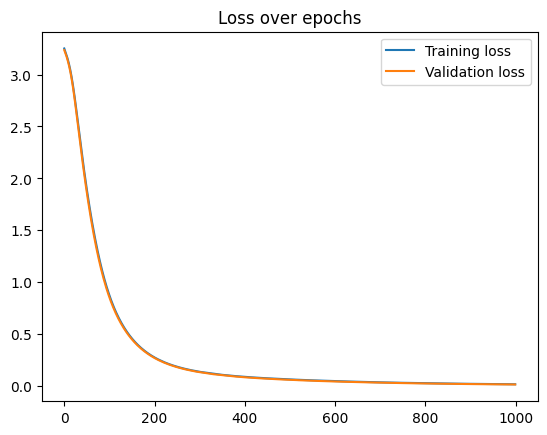

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Save Model to Storage

In [19]:
# Save model for model inference
# Save the model's state_dict
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model.pth') # Save

# Test Trained model

In [36]:
def predict(model, input_landmarks):
    model.eval()
    with torch.no_grad():
        input_landmarks = input_landmarks.unsqueeze(0).to(DEVICE)
        outputs = model(input_landmarks)
    return outputs

In [37]:
landmarks, label = dataset[4000]
print(landmarks)

tensor([0.1923, 0.6914, 0.2643, 0.6740, 0.3293, 0.6314, 0.3821, 0.6032, 0.4171,
        0.5628, 0.3040, 0.4112, 0.3715, 0.3840, 0.3938, 0.4640, 0.3918, 0.5358,
        0.2489, 0.3666, 0.2850, 0.2062, 0.3047, 0.1009, 0.3162, 0.0000, 0.1853,
        0.3766, 0.1696, 0.2220, 0.1578, 0.1208, 0.1535, 0.0219, 0.1268, 0.4355,
        0.0662, 0.3362, 0.0274, 0.2749, 0.0000, 0.2059])


In [38]:

probabilities = predict(model, landmarks)
print(probabilities)

tensor([[-3.8939e+01, -9.1307e+00, -9.7967e+00, -3.4667e+01, -1.1646e+01,
         -3.3039e-04, -4.5319e+01, -2.0046e+01, -1.1930e+01, -2.2799e+01,
         -4.7197e+01, -3.4579e+01, -4.2120e+01, -1.7080e+01, -4.3368e+01,
         -3.1813e+01, -1.2601e+01, -3.8981e+01, -2.9321e+01, -6.3177e+01,
         -1.8388e+01, -3.7719e+01, -1.0931e+01, -6.1931e+01, -2.5760e+01,
         -8.9498e+00]], device='cuda:0')


In [48]:
result = torch.exp(probabilities)
print(result)

tensor([[1.2281e-17, 1.0829e-04, 5.5635e-05, 8.7950e-16, 8.7532e-06, 9.9967e-01,
         2.0816e-20, 1.9677e-09, 6.5864e-06, 1.2540e-10, 3.1825e-21, 9.6051e-16,
         5.0981e-19, 3.8205e-08, 1.4641e-19, 1.5261e-14, 3.3694e-06, 1.1767e-17,
         1.8455e-13, 3.6512e-28, 1.0331e-08, 4.1561e-17, 1.7891e-05, 1.2701e-27,
         6.4921e-12, 1.2976e-04]], device='cuda:0')


In [50]:
for r in result[0]:
    print(str(r))

tensor(1.2281e-17, device='cuda:0')
tensor(0.0001, device='cuda:0')
tensor(5.5635e-05, device='cuda:0')
tensor(8.7950e-16, device='cuda:0')
tensor(8.7532e-06, device='cuda:0')
tensor(0.9997, device='cuda:0')
tensor(2.0816e-20, device='cuda:0')
tensor(1.9677e-09, device='cuda:0')
tensor(6.5864e-06, device='cuda:0')
tensor(1.2540e-10, device='cuda:0')
tensor(3.1825e-21, device='cuda:0')
tensor(9.6051e-16, device='cuda:0')
tensor(5.0981e-19, device='cuda:0')
tensor(3.8205e-08, device='cuda:0')
tensor(1.4641e-19, device='cuda:0')
tensor(1.5261e-14, device='cuda:0')
tensor(3.3694e-06, device='cuda:0')
tensor(1.1767e-17, device='cuda:0')
tensor(1.8455e-13, device='cuda:0')
tensor(3.6512e-28, device='cuda:0')
tensor(1.0331e-08, device='cuda:0')
tensor(4.1561e-17, device='cuda:0')
tensor(1.7891e-05, device='cuda:0')
tensor(1.2701e-27, device='cuda:0')
tensor(6.4921e-12, device='cuda:0')
tensor(0.0001, device='cuda:0')


In [51]:
print(label)

tensor(5)
